# **Quora Question Similarity Detection**

### **Natural Language Processing and Text Analytics**

*Dario Patzi Chavez - 177125*

*Mikael Karlsen Hauglid - 177121*

*Sander Thomasrud - 176169*

In [ ]:
# Installs
#%pip install xformers

#%pip install tensorflow gensim tensorflow-hub sentence-transformers datasets transformers accelerate scipy torch gensim

#%pip install torchvision --upgrade

In [ ]:
# Updating gensim
#pip --force-reinstall gensim
#%pip install gensim --upgrade

In [1]:
# Imports

 # General
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from datasets import Dataset, DatasetDict

# NLP
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Modelling related
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, log_loss, accuracy_score, precision_score, recall_score
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback


# Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers import InputExample
from torch.utils.data import DataLoader

# Downloaders
import gensim.downloader as api
import tensorflow_hub as hub
import os
import requests
import zipfile

# Fixes for warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Loading NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Loading word2vec
word2vec = api.load("word2vec-google-news-300")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Mounting drive - Run if using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Loading data

In [4]:
current_path = dario_drive_path

df = pd.read_csv(current_path + "quora_duplicate_questions.csv")

# Taking a look at the first rows
display(df.head(5))

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,False
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,False
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,False
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,False
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,False


## EDA

### Missing Values

In [5]:
# Checking for missing values
display(df.isnull().sum())

,0
id,0
qid1,0
qid2,0
question1,1
question2,3
is_duplicate,0


In [6]:
# Dropping all rows with missing values
df = df.dropna()

# Checking again for missing values
display(df.isnull().sum())

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


### Duplicates

In [7]:
# Checking for duplicates
duplicates = df.duplicated(subset=['question1', 'question2']).sum()

print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 5


### Distributions

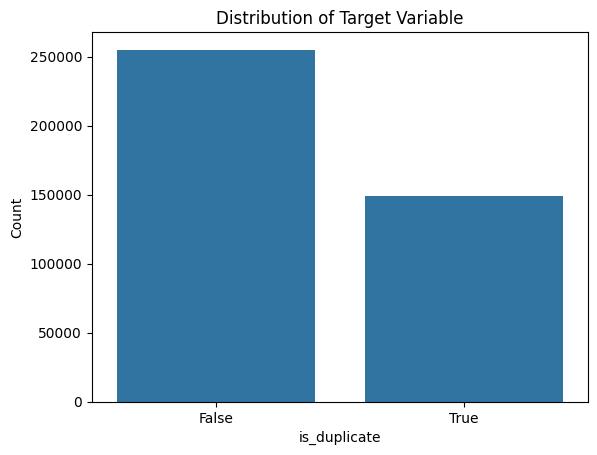

In [8]:
# Distribution of the target variable using Seaborn
sns.countplot(x='is_duplicate', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('is_duplicate')
plt.ylabel('Count')
plt.show()


Length of Question 1:

count    404347.000000
mean         10.941845
std           5.428689
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         125.000000
Name: question1_length, dtype: float64

Length of Question 2:

count    404347.000000
mean         11.181181
std           6.305295
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
Name: question2_length, dtype: float64


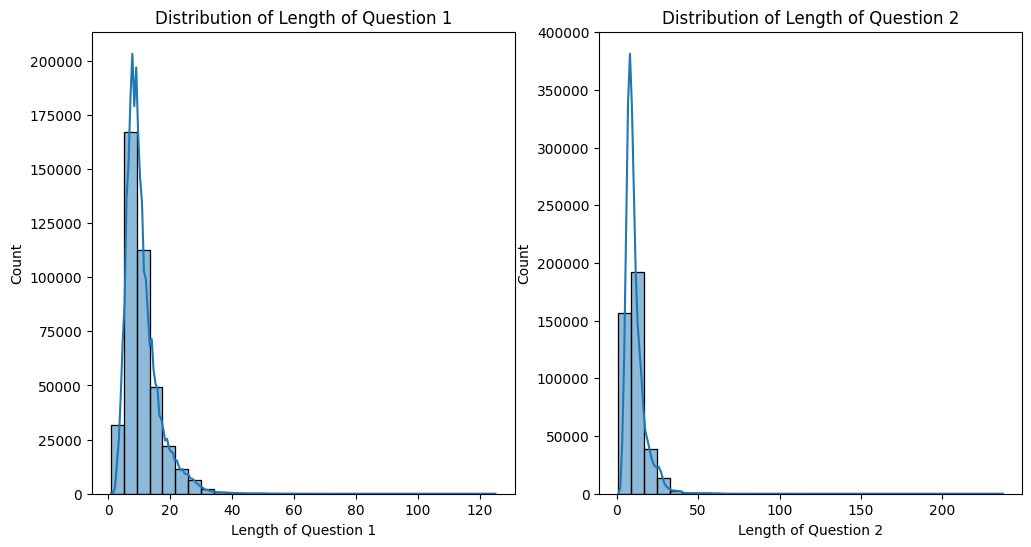

In [9]:
# Checking distribution of length of questions

# Calculating the length of each question
df['question1_length'] = df['question1'].apply(lambda x: len(str(x).split()))
df['question2_length'] = df['question2'].apply(lambda x: len(str(x).split()))

# Looking at the numbers first
print(f"\nLength of Question 1:\n\n{df['question1_length'].describe()}")
print(f"\nLength of Question 2:\n\n{df['question2_length'].describe()}")

# Plotting distribution of Question 1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['question1_length'], bins=30, kde=True)
plt.title('Distribution of Length of Question 1')
plt.xlabel('Length of Question 1')
plt.ylabel('Count')

# Plotting distribution of Question 2
plt.subplot(1, 2, 2)
sns.histplot(df['question2_length'], bins=30, kde=True)
plt.title('Distribution of Length of Question 2')
plt.xlabel('Length of Question 2')
plt.ylabel('Count')
plt.show()

As seen above, the length of the questions vary a lot.

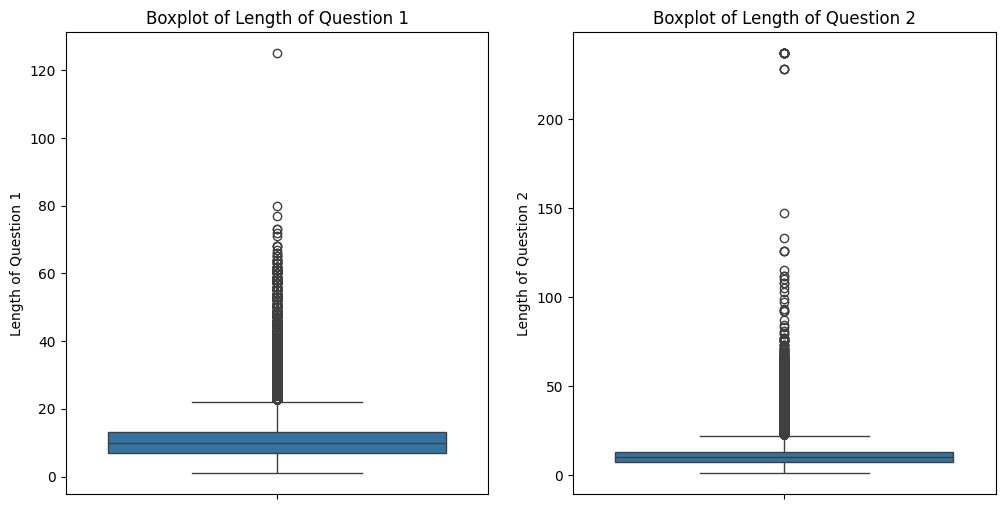

In [10]:
# Now checking with boxplots
plt.figure(figsize=(12, 6))

# Boxplot of length of Question 1
plt.subplot(1, 2, 1)
sns.boxplot(y='question1_length', data=df)
plt.title('Boxplot of Length of Question 1')
plt.ylabel('Length of Question 1')

# Boxplot of length of Question 2
plt.subplot(1, 2, 2)
sns.boxplot(y='question2_length', data=df)
plt.title('Boxplot of Length of Question 2')
plt.ylabel('Length of Question 2')

# Sharing the y-axis
plt.show()

In [11]:
""" Add back to remove outliers
# Removing all rows with length of question 1 or 2 greater than 100
df = df[(df['question1_length'] <= 100) & (df['question2_length'] <= 100)]

# Checking the distributions again
# Now checking with boxplots
plt.figure(figsize=(12, 6))

# Boxplot of length of Question 1
plt.subplot(1, 2, 1)
sns.boxplot(y='question1_length', data=df)
plt.title('Boxplot of Length of Question 1')
plt.ylabel('Length of Question 1')

# Boxplot of length of Question 2
plt.subplot(1, 2, 2)
sns.boxplot(y='question2_length', data=df)
plt.title('Boxplot of Length of Question 2')
plt.ylabel('Length of Question 2')

# Sharing the y-axis
plt.show()
"""

" Add back to remove outliers\n# Removing all rows with length of question 1 or 2 greater than 100\ndf = df[(df['question1_length'] <= 100) & (df['question2_length'] <= 100)]\n\n# Checking the distributions again\n# Now checking with boxplots\nplt.figure(figsize=(12, 6))\n\n# Boxplot of length of Question 1\nplt.subplot(1, 2, 1)\nsns.boxplot(y='question1_length', data=df)\nplt.title('Boxplot of Length of Question 1')\nplt.ylabel('Length of Question 1')\n\n# Boxplot of length of Question 2\nplt.subplot(1, 2, 2)\nsns.boxplot(y='question2_length', data=df)\nplt.title('Boxplot of Length of Question 2')\nplt.ylabel('Length of Question 2')\n\n# Sharing the y-axis\nplt.show()\n"

### Questions including Math (equations)

Our dataset contains 691 math based questions. We should explicitly evaluate how our model performs on these questions to determine their impact.


In [12]:
# Return where question1 or question2 contains "[math]"
math_observations = df[df['question1'].str.contains('\[math\]') | df['question2'].str.contains('\[math\]')]

# Displaying the number of observations with "[math]"
print(f"\nNumber of observations with '[math]': {len(math_observations)}")

# Displaying the first few observations with "[math]"
display(math_observations.head(5))


Number of observations with '[math]': 691


,id,qid1,qid2,question1,question2,is_duplicate,question1_length,question2_length
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,False,11,9
362,362,725,726,How do I find the zeros of the polynomial func...,How would you find the zero of the function fo...,False,11,14
764,764,1529,1530,What is [math]x[/math] if [math]x+\left(\dfrac...,What is [math]\mathop {\lim}\limits_{x \to 0^+...,False,6,6
1275,1275,2551,2552,How do I integrate [math]v^3(a^2-v^2)^{\frac{1...,How do I integrate [math]\frac{x^2}{x^2-1}[/ma...,False,7,5
1658,1658,3317,3318,What is the formula of [math](a+b)^3[/math]?,How can I be great at math?,False,6,7


## Data Preparation

In [13]:
# REMOVE THIS SECTION AFTERWARDS

# Downsampling the dataset to run training faster
# df = df.sample(n=1000, random_state=42)

#### Pre-processing 1: For all models

In [14]:
# Making all questions lowercase
df['question1'] = df['question1'].str.lower()
df['question2'] = df['question2'].str.lower()

# Removing extra spaces
df['question1'] = df['question1'].str.strip().str.replace(r'\s+', ' ', regex=True)
df['question2'] = df['question2'].str.strip().str.replace(r'\s+', ' ', regex=True)

# Drop duplicates
df = df.drop_duplicates(subset=['question1', 'question2'])

# Converting target variable to integer
df['is_duplicate'] = df['is_duplicate'].map({False: 0, True: 1})

<ipython-input-14-d675097e1ffc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_duplicate'] = df['is_duplicate'].map({False: 0, True: 1})


In [15]:
# Saving a duplicate of the dataset for BERT use later
bert_df = df.copy()

#### Feature Engineering 1: String-based features

This section adds 8 features to the dataset, simply from the string-based properties of each question.

In [16]:
# Adding the total number of characters (including whitespace) in the questions as features
df['question1_length'] = df['question1'].apply(lambda x: len(str(x)))
df['question2_length'] = df['question2'].apply(lambda x: len(str(x)))

# Adding the difference in length of the questions as a feature
df['length_diff'] = df['question1_length'] - df['question2_length']

# Adding the number of characters (excluding whitespace) in the questions as features
df['question1_char_length'] = df['question1'].apply(lambda x: len(str(x).replace(" ", "")))
df['question2_char_length'] = df['question2'].apply(lambda x: len(str(x).replace(" ", "")))

# Adding the number of words in the questions as features
df['question1_word_count'] = df['question1'].apply(lambda x: len(str(x).split()))
df['question2_word_count'] = df['question2'].apply(lambda x: len(str(x).split()))

# Adding the number of common words in the questions as features
df['common_word_count'] = df.apply(lambda x: len(set(str(x['question1']).split()) & set(str(x['question2']).split())), axis=1)

#### Pre-processing 2: For all models except BERTs

In [18]:
# General preprocessing function
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation
    tokens = [word for word in tokens if word.isalpha()]

    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Applying the preprocessing function to both questions
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

#### Train-Val-Test Split

In [19]:
# Split function
def split_data(df):

    # Dropping columns
    X = df.drop(columns=['id', 'qid1', 'qid2', 'is_duplicate'])

    # Splitting the data into features and target variable
    y = df['is_duplicate']

    # Splitting the data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

    # Splitting the test data into test and validation sets
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Printing the shapes of the training, validation, and test sets
    print(f"Training set shapes:\n - Features: {X_train.shape}\n - Target: {y_train.shape}")
    print(f"Validation set shapes:\n - Features: {X_val.shape}\n - Target: {y_val.shape}")
    print(f"Test set shapes:\n - Features: {X_test.shape}\n - Target: {y_test.shape}")

    # Returing the split data
    return X_train, X_val, X_test, y_train, y_val, y_test

# Applying to the processed dataset
print("Normal data:\n")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

# Applying to the BERT dataset
print("\nBERT data:\n")
X_train_bert, X_val_bert, X_test_bert, y_train_bert, y_val_bert, y_test_bert = split_data(bert_df)

Normal data:

Training set shapes:
 - Features: (282792, 10)
 - Target: (282792,)
Validation set shapes:
 - Features: (60598, 10)
 - Target: (60598,)
Test set shapes:
 - Features: (60599, 10)
 - Target: (60599,)

BERT data:

Training set shapes:
 - Features: (282792, 4)
 - Target: (282792,)
Validation set shapes:
 - Features: (60598, 4)
 - Target: (60598,)
Test set shapes:
 - Features: (60599, 4)
 - Target: (60599,)


#### Downsampling the Training set (DROP?)

In [20]:
# Creating a downsampling function that prints out number of samples dropped
def downsample(X, y, dataset_name=""):

    # Concatenating the training data
    X = pd.concat([X, y], axis=1)

    # Saving number of samples before downsampling
    num_samples_before = X.shape[0]

    # Downsampling the majority class
    X_majority = X[X['is_duplicate'] == 0]
    X_minority = X[X['is_duplicate'] == 1]
    X_majority_downsampled = resample(X_majority,
                                         replace=False,     # sample without replacement
                                         n_samples=len(X_minority),    # to match minority class
                                         random_state=42) # reproducible results

    # Combining minority and downsampled majority class
    X_downsampled = pd.concat([X_majority_downsampled, X_minority])

    # Splitting the downsampled training data into X and y
    X = X_downsampled.drop('is_duplicate', axis=1)
    y = X_downsampled['is_duplicate']

    # Extracting the number of samples after downsampling
    num_samples_after = X.shape[0]

    # Displaying the number of samples dropped
    print(f"Number of samples dropped for {dataset_name}-set: {num_samples_before - num_samples_after}")

    return X, y

# Applying the downsampling function to the processed training set
X_train, y_train = downsample(X_train, y_train, "training")

# Applying the downsampling function to the BERT training set
X_train_bert, y_train_bert = downsample(X_train_bert, y_train_bert, "BERT training")

Number of samples dropped for training-set: 74008
Number of samples dropped for BERT training-set: 74008


### Vectorization

In [21]:
# Helper functions to convert back to DataFrames

def create_df_sparse(col1_sparse, col2_sparse):
    return pd.DataFrame({
        'question1': [row.toarray().flatten() for row in col1_sparse],
        'question2': [row.toarray().flatten() for row in col2_sparse]
    })

def create_df_dense(col1_dense, col2_dense):
    return pd.DataFrame({
        'question1': [row for row in col1_dense],
        'question2': [row for row in col2_dense]
    })

# Helper function to vectorize and convert back to DataFrame
def vectorize_and_convert(vectorizer, X_train, X_val, X_test):

    # Fit on combined question1 and question2 (but separately)
    vectorizer.fit(
        pd.concat([
            X_train['question1'].astype(str),
            X_train['question2'].astype(str)
        ])
    )

    # Transform each question column separately
    X_train_q1 = vectorizer.transform(X_train['question1'].astype(str))
    X_train_q2 = vectorizer.transform(X_train['question2'].astype(str))
    X_val_q1 = vectorizer.transform(X_val['question1'].astype(str))
    X_val_q2 = vectorizer.transform(X_val['question2'].astype(str))
    X_test_q1 = vectorizer.transform(X_test['question1'].astype(str))
    X_test_q2 = vectorizer.transform(X_test['question2'].astype(str))

    # Combine the vectors
    X_train = hstack([X_train_q1, X_train_q2])
    X_val = hstack([X_val_q1, X_val_q2])
    X_test = hstack([X_test_q1, X_test_q2])

    # Convert to DataFrame
    X_train_df = create_df_sparse(X_train_q1, X_train_q2)
    X_val_df = create_df_sparse(X_val_q1, X_val_q2)
    X_test_df = create_df_sparse(X_test_q1, X_test_q2)

    # Returning the DataFrames
    return X_train_df, X_val_df, X_test_df


#### Bag of Words

In [22]:
# Create the vectorizer
bow_vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    max_features=5000
)

# Applying the vectorization and conversion to DataFrames
X_train_bow_df, X_val_bow_df, X_test_bow_df = vectorize_and_convert(bow_vectorizer, X_train, X_val, X_test)

# Checking the first few rows of the BOW vectorized training set
display(X_train_bow_df.head(5))

,question1,question2
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### TF-IDF

In [23]:
# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000
)

# Applying the TF-IDF vectorization and conversion to DataFrames
X_train_tfidf_df, X_val_tfidf_df, X_test_tfidf_df = vectorize_and_convert(tfidf_vectorizer, X_train, X_val, X_test)

# Checking the first few rows of the TF-IDF vectorized training set
display(X_train_tfidf_df.head(5))

,question1,question2
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### SentenceBERT

In [24]:
# Setting the SentenceBERT model name
model_name1 = "all-MiniLM-L6-v2"

In [25]:
# Convert data to HuggingFace Dataset
hf_train = Dataset.from_pandas(X_train_bert.reset_index(drop=True))
hf_val = Dataset.from_pandas(X_val_bert.reset_index(drop=True))
hf_test = Dataset.from_pandas(X_test_bert.reset_index(drop=True))

# Combine into a DatasetDict (like before)
hf_dataset = DatasetDict({
    "train": hf_train,
    "val": hf_val,
    "test": hf_test
})

In [26]:
# Initializing the SentenceTransformer model
model = SentenceTransformer(model_name1, trust_remote_code=True)

# Convert your dataset into InputExamples
train_examples = [
    InputExample(texts=[q1, q2], label=float(label))
    for q1, q2, label in zip(
        hf_dataset['train']['question1'],
        hf_dataset['train']['question2'],
        y_train
    )
]

# Create a DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

# Setting loss function to cosine similarity
train_loss = losses.CosineSimilarityLoss(model=model)

# Fine-tune the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    warmup_steps=100,
    output_path='output/sbert-cosine-duplicate'
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: mikaelkarlsenhauglid (mikaelkarlsenhauglid-copenhagen-business-school) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.151000
1000,0.131700
1500,0.129000
2000,0.124700
2500,0.120600
3000,0.120600
3500,0.117800
4000,0.117800
4500,0.115900
5000,0.116700


In [27]:
# Encode question pairs using the fine-tuned SBERT model
X_train_q1_embeddings = model.encode(hf_dataset['train']['question1'], convert_to_numpy=True)
X_train_q2_embeddings = model.encode(hf_dataset['train']['question2'], convert_to_numpy=True)
X_val_q1_embeddings = model.encode(hf_dataset['val']['question1'], convert_to_numpy=True)
X_val_q2_embeddings = model.encode(hf_dataset['val']['question2'], convert_to_numpy=True)
X_test_q1_embeddings = model.encode(hf_dataset['test']['question1'], convert_to_numpy=True)
X_test_q2_embeddings = model.encode(hf_dataset['test']['question2'], convert_to_numpy=True)

# Wrap into DataFrames (if needed)
X_train_sbert_df = create_df_dense(X_train_q1_embeddings, X_train_q2_embeddings)
X_val_sbert_df = create_df_dense(X_val_q1_embeddings, X_val_q2_embeddings)
X_test_sbert_df = create_df_dense(X_test_q1_embeddings, X_test_q2_embeddings)

# Checking the first few rows of the SBERT vectorized training set
display(X_train_sbert_df.head(5))

,question1,question2
0,"[0.046487432, 0.018743914, -0.101857446, -0.04...","[0.026263848, 0.016416393, 0.1302665, 0.021039..."
1,"[0.0056219385, -0.056756143, 0.056108743, 0.06...","[-0.06056269, -0.0009058504, -0.005487517, 0.0..."
2,"[-0.10429934, 0.062662676, 0.08652634, 0.02200...","[0.020999575, 0.013643495, -0.04303579, 0.0339..."
3,"[0.047608826, -0.14364481, 0.017021935, -0.014...","[-0.016689898, 0.063782215, -0.043881666, -0.0..."
4,"[0.0011892599, 0.094160594, 0.0128791025, -0.0...","[0.0033280363, 0.017774982, -0.04732752, 0.008..."


### Feature Engineering 2: Vector Similarity Features

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import minkowski, cityblock, euclidean

# Helper function to add vector similarity features and merge with original feature set
def add_vector_features(vector_df, feature_df):

    # Copying feature_df to avoid modifying the original
    new_df = feature_df.copy()

    # Extracting vectors
    q1_vectors = np.array([v for v in vector_df['question1'].values])
    q2_vectors = np.array([v for v in vector_df['question2'].values])

    # Calculating cosine similarity
    cosine_sim = np.array([
        cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))[0][0]
        for v1, v2 in zip(q1_vectors, q2_vectors)
    ])

    # Calculating Minkowski distance
    minkowski_dist = np.array([
        minkowski(v1, v2) for v1, v2 in zip(q1_vectors, q2_vectors)
    ])

    # Calculating Manhattan distance
    manhattan_dist = np.array([
        cityblock(v1, v2) for v1, v2 in zip(q1_vectors, q2_vectors)
    ])

    # Calculating Euclidean distance
    euclidean_dist = np.array([
        euclidean(v1, v2) for v1, v2 in zip(q1_vectors, q2_vectors)
    ])

    # Adding the new features to the DataFrame
    new_df['cosine_similarity'] = cosine_sim
    new_df['minkowski_distance'] = minkowski_dist
    new_df['manhattan_distance'] = manhattan_dist
    new_df['euclidean_distance'] = euclidean_dist

    # Returning the new DataFrame with added features
    return new_df

# BOW
X_train_bow = add_vector_features(X_train_bow_df, X_train)
X_val_bow = add_vector_features(X_val_bow_df, X_val)
X_test_bow = add_vector_features(X_test_bow_df, X_test)

# TF-IDF
X_train_tfidf = add_vector_features(X_train_tfidf_df, X_train)
X_val_tfidf = add_vector_features(X_val_tfidf_df, X_val)
X_test_tfidf = add_vector_features(X_test_tfidf_df, X_test)

# SBERT
X_train_sbert = add_vector_features(X_train_sbert_df, X_train_bert)
X_val_sbert = add_vector_features(X_val_sbert_df, X_val_bert)
X_test_sbert = add_vector_features(X_test_sbert_df, X_test_bert)

## Modelling

In [29]:
# Columns to drop before training
columns_to_drop = ['question1', 'question2']

# BOW
X_train_bow = X_train_bow.drop(columns=columns_to_drop)
X_val_bow = X_val_bow.drop(columns=columns_to_drop)
X_test_bow = X_test_bow.drop(columns=columns_to_drop)

# TF-IDF
X_train_tfidf = X_train_tfidf.drop(columns=columns_to_drop)
X_val_tfidf = X_val_tfidf.drop(columns=columns_to_drop)
X_test_tfidf = X_test_tfidf.drop(columns=columns_to_drop)

# SBERT
X_train_sbert = X_train_sbert.drop(columns=columns_to_drop)
X_val_sbert = X_val_sbert.drop(columns=columns_to_drop)
X_test_sbert = X_test_sbert.drop(columns=columns_to_drop)

### Baseline: Cosine Similarity Threshold

In [30]:
# Helper function to plot results across different thresholds
def cosine_baseline(sim_scores, true_labels, thresholds=np.linspace(-1, 1, 20)):
    # Setting up score list
    f1_scores = []

    # Iterating thresholds
    for t in thresholds:
        preds = (sim_scores > t).astype(int)
        f1 = f1_score(true_labels, preds)
        f1_scores.append(f1)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.title("F1 Score vs. Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.xticks(thresholds)
    plt.show()

    # Return the threshold with highest F1 score
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f"Best F1 Score: {best_f1:.4f} at threshold {best_threshold:.4f}")
    return best_threshold

# Helper function to evaluate
def evaluate_baseline(sim_scores, true_labels, threshold):

    # Confusion matrix
    preds = (sim_scores > threshold).astype(int)
    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix at Threshold {threshold:.2f}")

    # Classification report
    report = classification_report(true_labels, preds, target_names=['Not Duplicate', 'Duplicate'], digits=3)
    print(f"Classification Report for Threshold {threshold:.2f}:\n")
    print(report)

    # Display
    plt.show()

#### Bag of Words

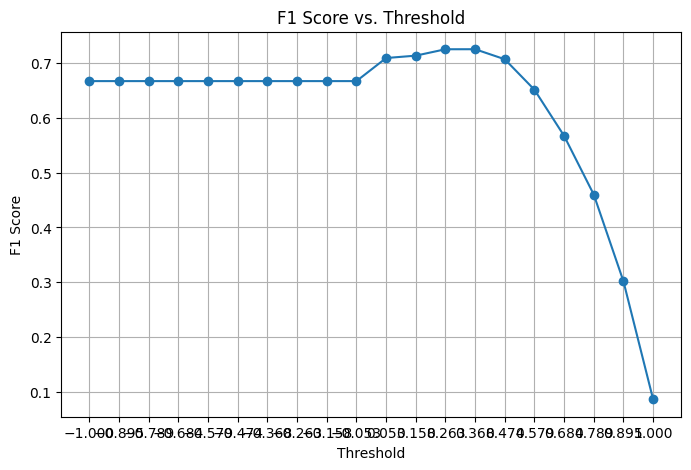

Best F1 Score: 0.7248 at threshold 0.3684
Classification Report for Threshold 0.37:

               precision    recall  f1-score   support

Not Duplicate      0.878     0.413     0.562     38189
    Duplicate      0.474     0.902     0.622     22409

     accuracy                          0.594     60598
    macro avg      0.676     0.658     0.592     60598
 weighted avg      0.729     0.594     0.584     60598



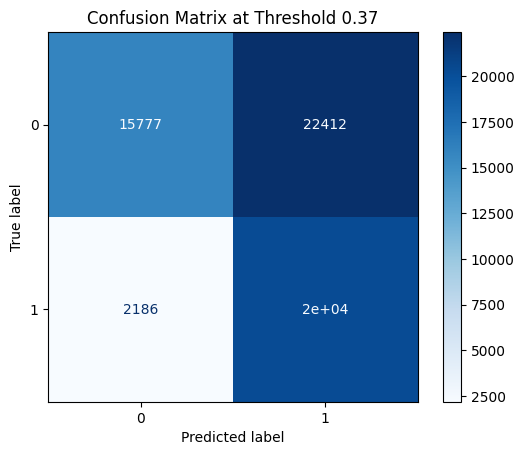

In [31]:
# Applying the evaluation function to BOW
bow_threshold = cosine_baseline(
    sim_scores=X_train_bow['cosine_similarity'],
    true_labels=y_train
)

# Evaluating on validation set using best threshold
evaluate_baseline(
    sim_scores=X_val_bow['cosine_similarity'],
    true_labels=y_val,
    threshold=bow_threshold
)

#### TF-IDF

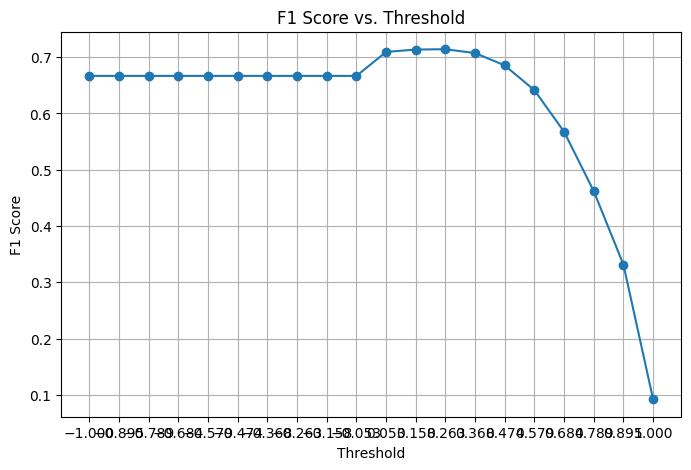

Best F1 Score: 0.7141 at threshold 0.2632
Classification Report for Threshold 0.26:

               precision    recall  f1-score   support

Not Duplicate      0.884     0.333     0.483     38189
    Duplicate      0.449     0.926     0.605     22409

     accuracy                          0.552     60598
    macro avg      0.667     0.629     0.544     60598
 weighted avg      0.723     0.552     0.528     60598



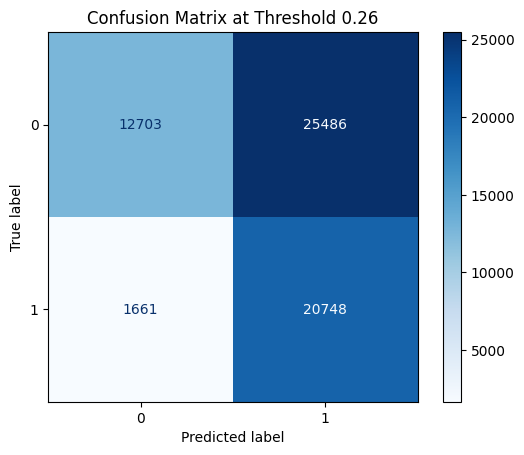

In [32]:
# Applying the evaluation function to TF-IDF
tfidf_threshold = cosine_baseline(
    sim_scores=X_train_tfidf['cosine_similarity'],
    true_labels=y_train
)

# Evaluating on validation set using best threshold
evaluate_baseline(
    sim_scores=X_val_tfidf['cosine_similarity'],
    true_labels=y_val,
    threshold=tfidf_threshold
)

#### SentenceBERT

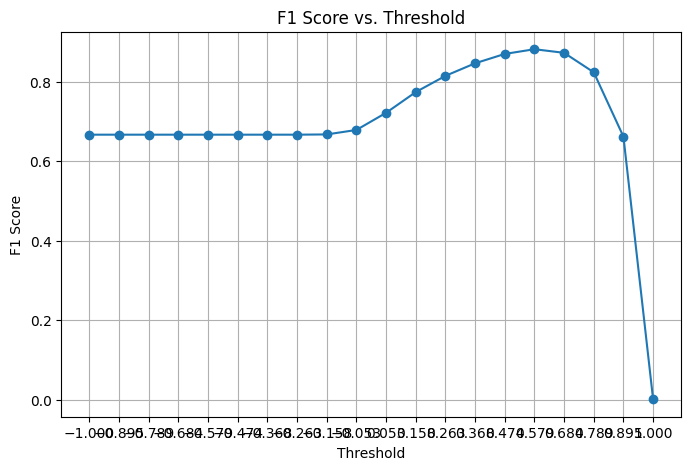

Best F1 Score: 0.8818 at threshold 0.5789
Classification Report for Threshold 0.58:

               precision    recall  f1-score   support

Not Duplicate      0.944     0.790     0.860     38189
    Duplicate      0.720     0.921     0.808     22409

     accuracy                          0.838     60598
    macro avg      0.832     0.855     0.834     60598
 weighted avg      0.861     0.838     0.841     60598



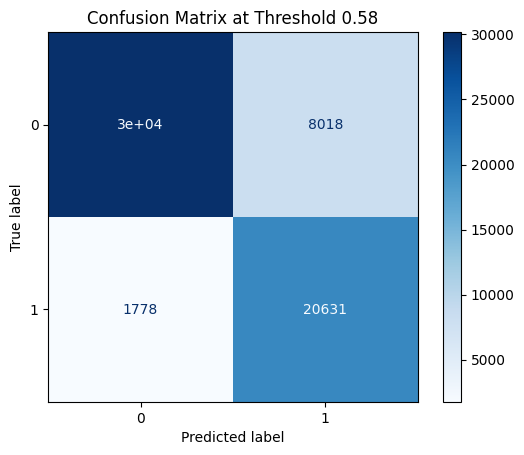

In [33]:
# Applying the evaluation function to SentenceBERT
sbert_threshold = cosine_baseline(
    sim_scores=X_train_sbert['cosine_similarity'],
    true_labels=y_train
)

# Evaluating on validation set using best threshold
evaluate_baseline(
    sim_scores=X_val_sbert['cosine_similarity'],
    true_labels=y_val,
    threshold=sbert_threshold
)

### Logistic Regression

In [34]:
# Helper function to run Logistic Regression
def run_logreg(X_train, y_train, X_val, y_val, feature_set_name):

    # Set up the pipeline
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, random_state=42)
    )

    # Define parameter grid
    param_grid = {
        'logisticregression__C': [0.01, 0.1, 1, 10, 100]
    }

    # Grid search
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Best model
    best_model = grid.best_estimator_

    # Predict on validation set
    y_pred = best_model.predict(X_val)

    # Evaluation
    print(f"\nBest C for {feature_set_name}: {grid.best_params_['logisticregression__C']}")
    print(f"\nClassification Report for {feature_set_name}:")
    print(classification_report(y_val, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['logisticregression'].classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {feature_set_name}')
    plt.show()

    return best_model

# Plotting the feature importances
def plot_feature_importances_lr(model, feature_names, title):
    importances = model.named_steps['logisticregression'].coef_[0]
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45)
    plt.xlim([-1, len(importances)])
    plt.show()

#### Bag of Words


Best C for Bag of Words: 0.01

Classification Report for Bag of Words:
              precision    recall  f1-score   support

           0       0.84      0.64      0.72     38189
           1       0.56      0.79      0.66     22409

    accuracy                           0.69     60598
   macro avg       0.70      0.71      0.69     60598
weighted avg       0.73      0.69      0.70     60598



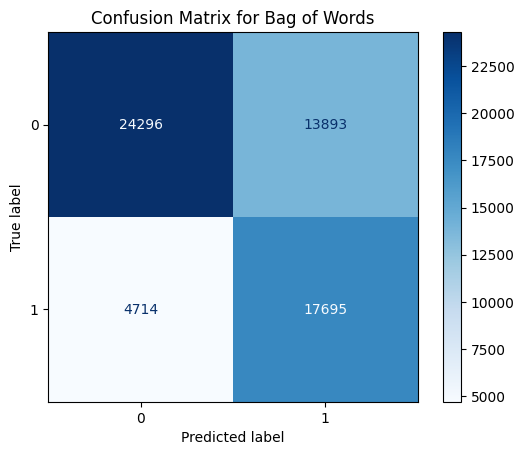

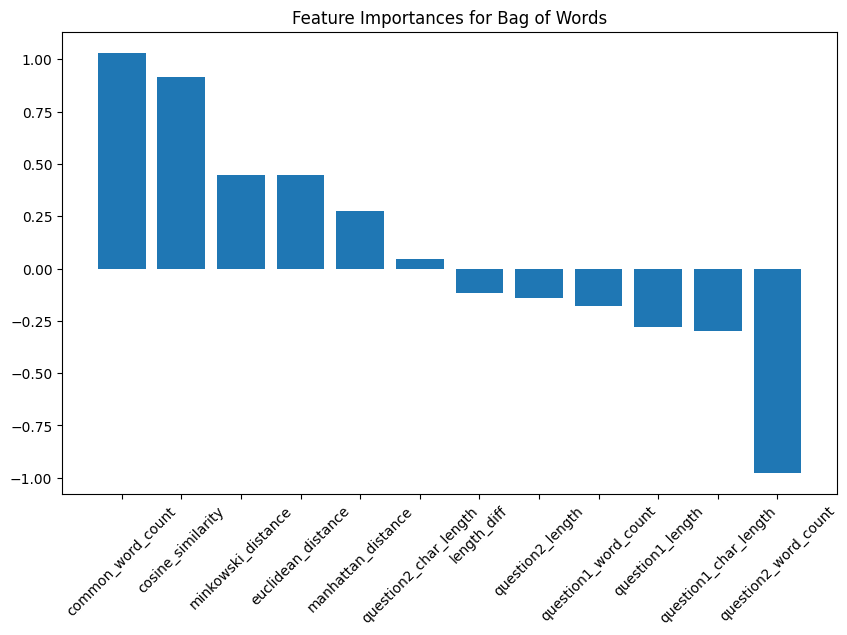

In [35]:
# Running the model on BOW features
best_model_bow_lr = run_logreg(X_train_bow, y_train, X_val_bow, y_val, 'Bag of Words')

# Plotting feature importances
plot_feature_importances_lr(best_model_bow_lr, X_train_bow.columns, 'Feature Importances for Bag of Words')

#### TF-IDF


Best C for TF-IDF: 100

Classification Report for TF-IDF:
              precision    recall  f1-score   support

           0       0.83      0.64      0.72     38189
           1       0.56      0.78      0.65     22409

    accuracy                           0.69     60598
   macro avg       0.69      0.71      0.68     60598
weighted avg       0.73      0.69      0.69     60598



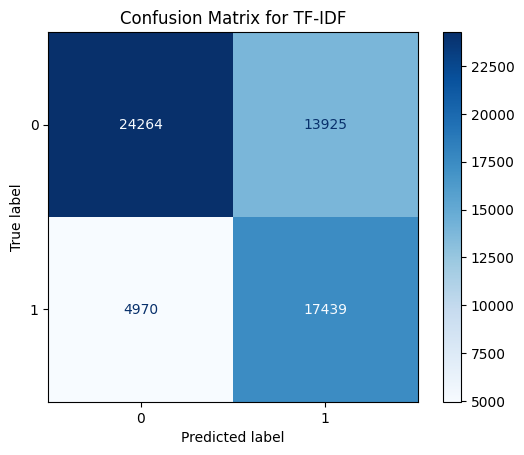

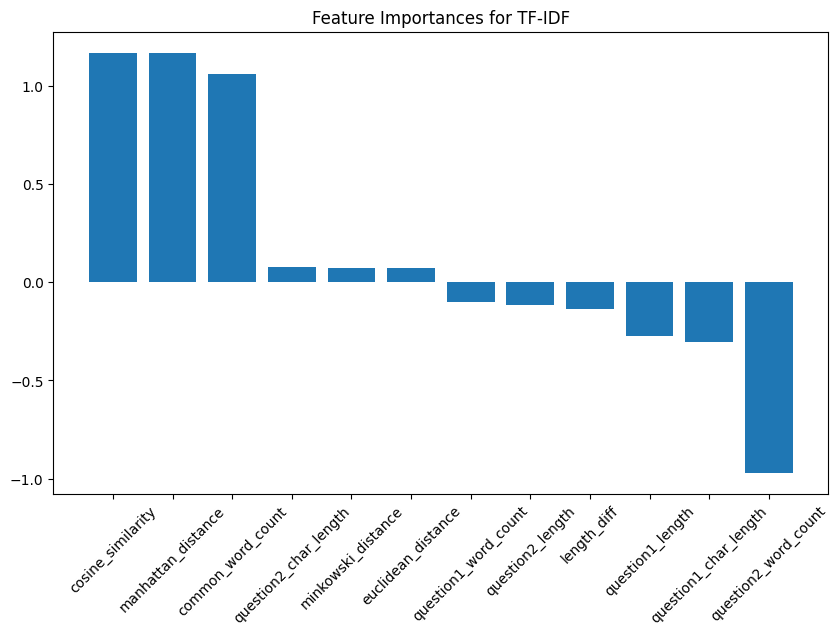

In [36]:
# Running the model on TFIDF features
best_model_tfidf_lr = run_logreg(X_train_tfidf, y_train, X_val_tfidf, y_val, 'TF-IDF')

# Plotting feature importances
plot_feature_importances_lr(best_model_tfidf_lr, X_train_tfidf.columns, 'Feature Importances for TF-IDF')

#### SentenceBERT


Best C for SentenceBERT: 0.1

Classification Report for SentenceBERT:
              precision    recall  f1-score   support

           0       0.93      0.83      0.87     38189
           1       0.75      0.89      0.81     22409

    accuracy                           0.85     60598
   macro avg       0.84      0.86      0.84     60598
weighted avg       0.86      0.85      0.85     60598



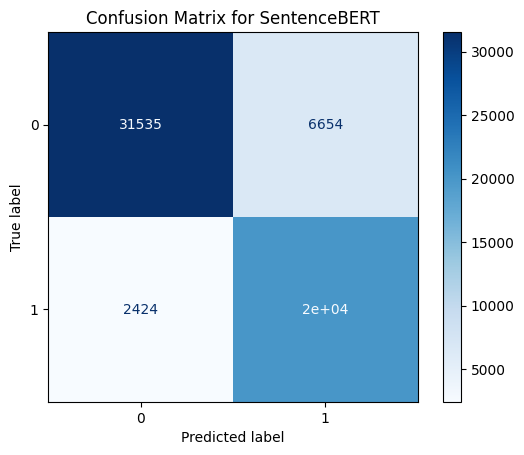

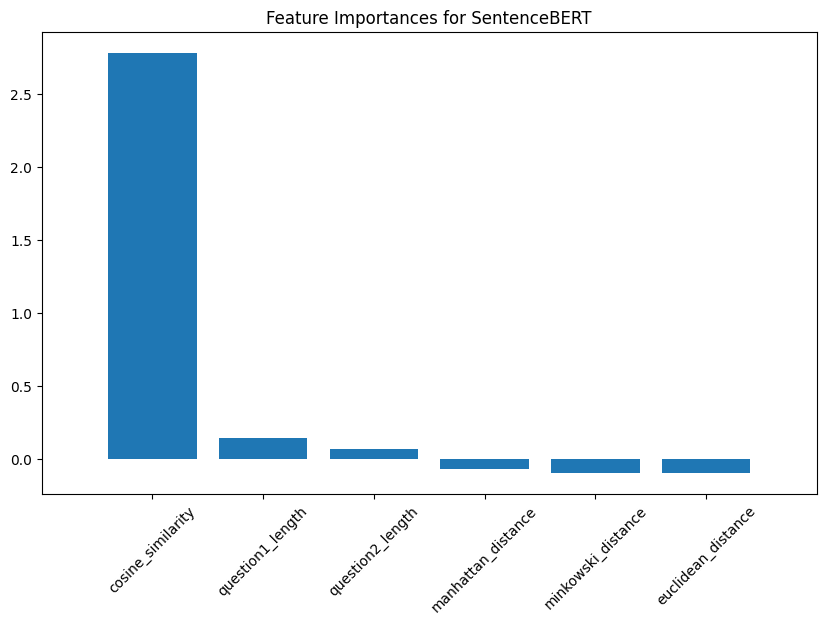

In [37]:
# Running the model on SentenceBERT features
best_model_sbert_lr = run_logreg(X_train_sbert, y_train, X_val_sbert, y_val, 'SentenceBERT')

# Plotting feature importances
plot_feature_importances_lr(best_model_sbert_lr, X_train_sbert.columns, 'Feature Importances for SentenceBERT')

### Naïve Bayes

In [38]:
# Helper function to run Naïve Bayes
def run_naive_bayes(X_train, y_train, X_val, y_val, feature_set_name):

    # Create pipeline
    pipeline = make_pipeline(
        MinMaxScaler(),
        MultinomialNB()
    )

    # Grid search
    param_grid = {
        'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]
    }

    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_

    # Predict on validation set
    y_pred = best_model.predict(X_val)

    print(f"\nBest alpha for {feature_set_name}: {grid.best_params_['multinomialnb__alpha']}")
    print(f"\nClassification Report for {feature_set_name}:")
    print(classification_report(y_val, y_pred))

    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['multinomialnb'].classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {feature_set_name}')
    plt.show()

    return best_model

#### Bag of Words


Best alpha for Bag of Words: 10.0

Classification Report for Bag of Words:
              precision    recall  f1-score   support

           0       0.77      0.62      0.68     38189
           1       0.51      0.68      0.59     22409

    accuracy                           0.64     60598
   macro avg       0.64      0.65      0.64     60598
weighted avg       0.67      0.64      0.65     60598



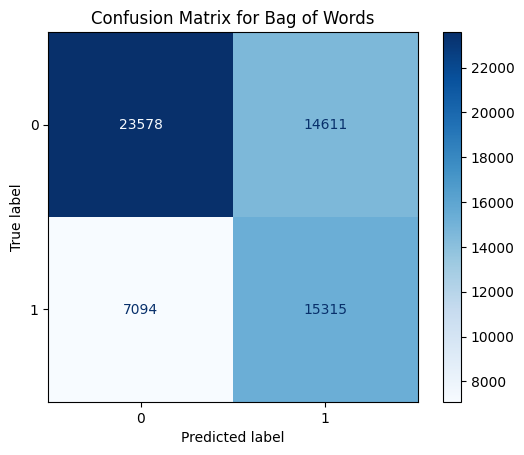

In [39]:
# Running the Naive Bayes model on BOW features
best_model_bow_nb = run_naive_bayes(X_train_bow, y_train, X_val_bow, y_val, 'Bag of Words')

#### TF-IDF


Best alpha for TF-IDF: 10.0

Classification Report for TF-IDF:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69     38189
           1       0.51      0.64      0.56     22409

    accuracy                           0.64     60598
   macro avg       0.63      0.64      0.63     60598
weighted avg       0.66      0.64      0.64     60598



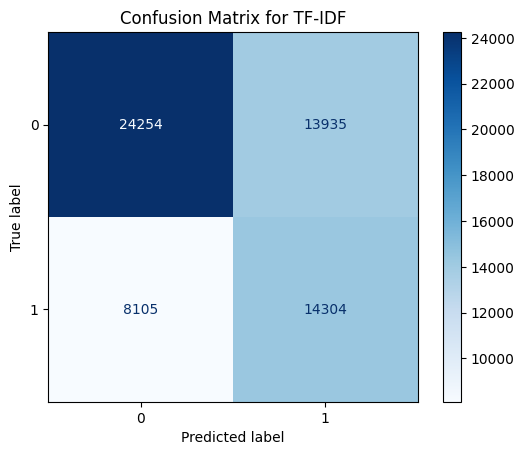

In [40]:
# Running the Naive Bayes model on TF-IDF features
best_model_tfidf_nb = run_naive_bayes(X_train_tfidf, y_train, X_val_tfidf, y_val, 'TF-IDF')

#### SentenceBERT


Best alpha for SentenceBERT: 10.0

Classification Report for SentenceBERT:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88     38189
           1       0.76      0.88      0.82     22409

    accuracy                           0.85     60598
   macro avg       0.84      0.86      0.85     60598
weighted avg       0.86      0.85      0.85     60598



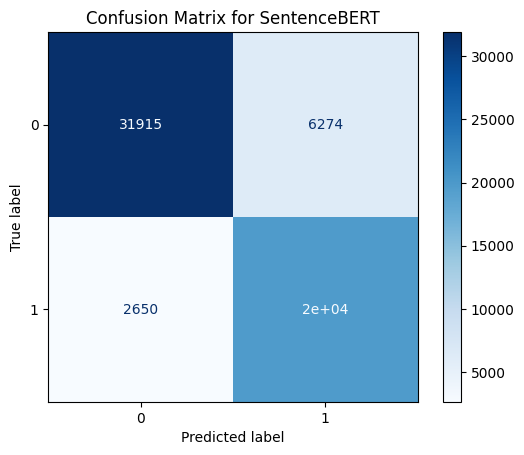

In [41]:
# Running the Naive Bayes model on SentenceBERT features
best_model_sbert_nb = run_naive_bayes(X_train_sbert, y_train, X_val_sbert, y_val, 'SentenceBERT')

### XGBoost

In [42]:
# Helper function to run XGBoost
def run_xgboost(X_train, y_train, X_val, y_val, feature_set_name):

    # Set up the pipeline (no scaler needed for XGBoost)
    pipeline = Pipeline([
        ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
    ])

    # Define parameter grid
    param_grid = {
        'xgb__n_estimators': [100, 200, 300, 400, 500],
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.1, 0.3]
    }

    # Grid search
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Best model
    best_model = grid.best_estimator_

    # Predict on validation set
    y_pred = best_model.predict(X_val)

    # Evaluation
    print(f"\nBest params for {feature_set_name}: {grid.best_params_}")
    print(f"\nClassification Report for {feature_set_name}:")
    print(classification_report(y_val, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['xgb'].classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {feature_set_name}')
    plt.show()

    return best_model

# Plotting the feature importances
def plot_feature_importances_xgb(model, feature_names, title):
    importances = model.named_steps['xgb'].feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45, ha='right')
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()

#### Bag of Words


Best params for Bag of Words: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 400}

Classification Report for Bag of Words:
              precision    recall  f1-score   support

           0       0.90      0.62      0.74     38189
           1       0.58      0.88      0.70     22409

    accuracy                           0.72     60598
   macro avg       0.74      0.75      0.72     60598
weighted avg       0.78      0.72      0.72     60598



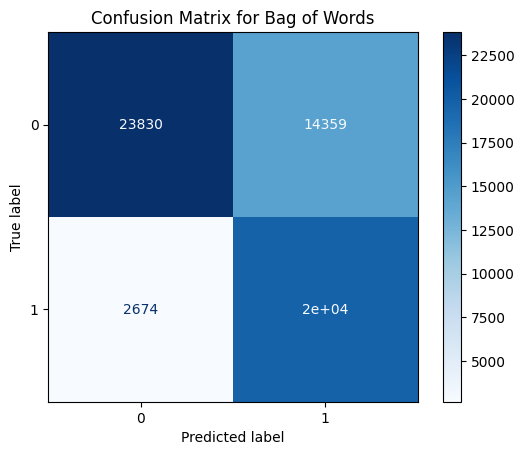

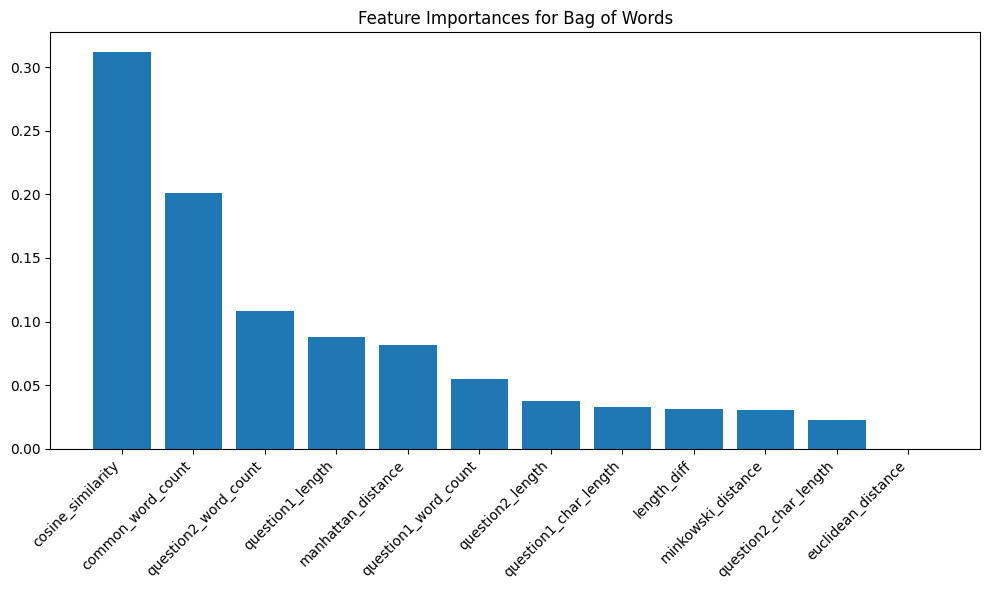

In [43]:
# Running the XGBoost model on BOW features
best_model_bow_xgb = run_xgboost(X_train_bow, y_train, X_val_bow, y_val, 'Bag of Words')

# Plotting feature importances
plot_feature_importances_xgb(best_model_bow_xgb, X_train_bow.columns, 'Feature Importances for Bag of Words')

#### TF-IDF


Best params for TF-IDF: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200}

Classification Report for TF-IDF:
              precision    recall  f1-score   support

           0       0.90      0.62      0.73     38189
           1       0.58      0.88      0.70     22409

    accuracy                           0.72     60598
   macro avg       0.74      0.75      0.72     60598
weighted avg       0.78      0.72      0.72     60598



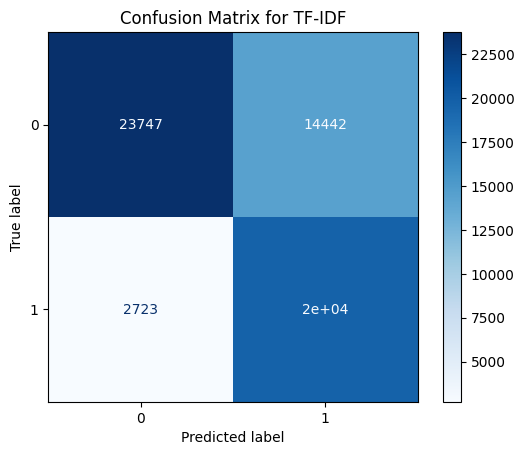

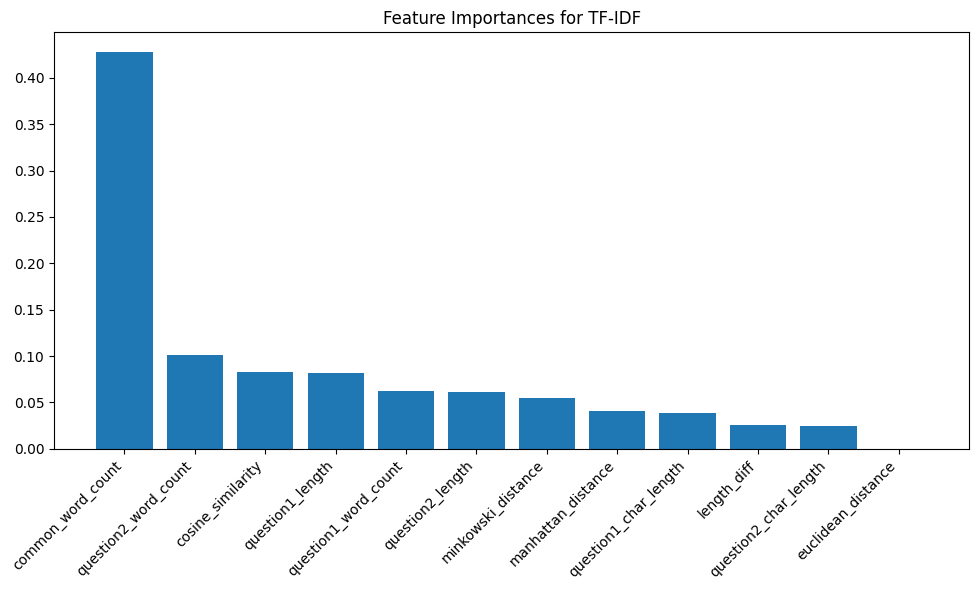

In [44]:
# Running the XGBoost model on TF-IDF features
best_model_tfidf_xgb = run_xgboost(X_train_tfidf, y_train, X_val_tfidf, y_val, 'TF-IDF')

# Plotting feature importances
plot_feature_importances_xgb(best_model_tfidf_xgb, X_train_tfidf.columns, 'Feature Importances for TF-IDF')

#### SentenceBERT


Best params for SentenceBERT: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 300}

Classification Report for SentenceBERT:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     38189
           1       0.75      0.90      0.82     22409

    accuracy                           0.85     60598
   macro avg       0.84      0.86      0.84     60598
weighted avg       0.86      0.85      0.85     60598



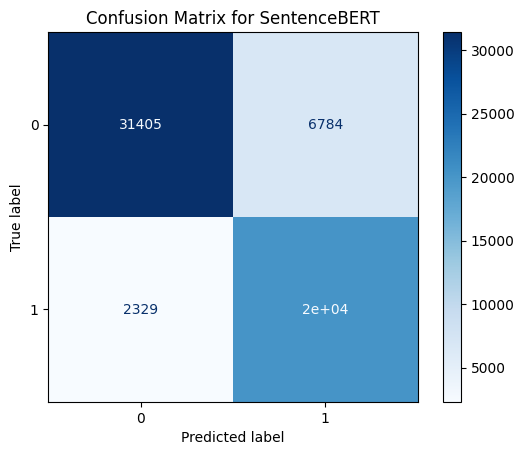

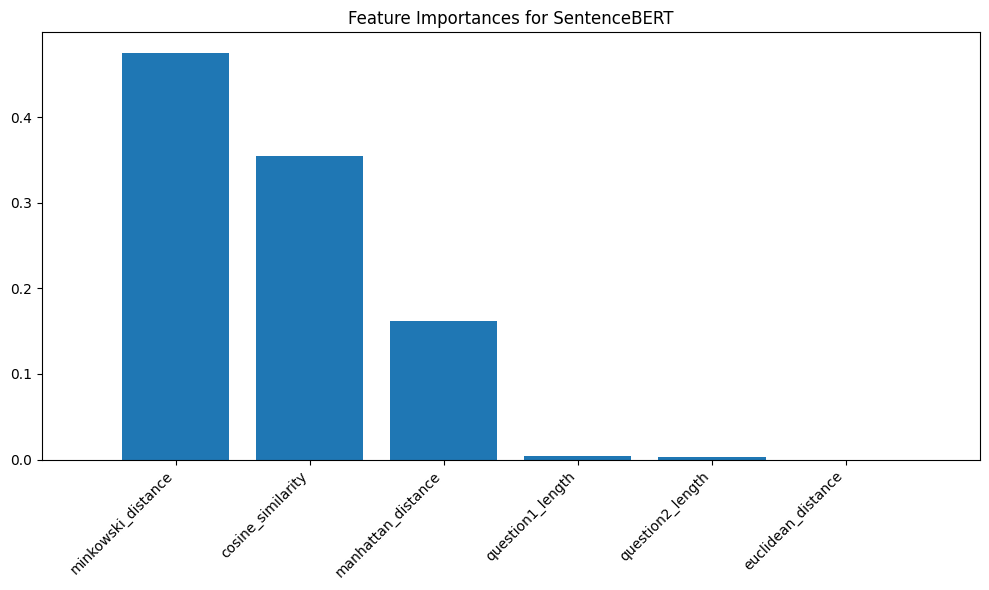

In [45]:
# Running the XGBoost model on SentenceBERT features
best_model_sbert_xgb = run_xgboost(X_train_sbert, y_train, X_val_sbert, y_val, 'SentenceBERT')

# Plotting feature importances
plot_feature_importances_xgb(best_model_sbert_xgb, X_train_sbert.columns, 'Feature Importances for SentenceBERT')

### Siamese Neural Network

#### Preparation

##### Processing

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Lambda, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
# Further preprocessing for The SNN model

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def prepare_snn_data(df, tokenizer=None, max_len=30, fit_tokenizer=True):

    # Removing punctuation
    df['q1_clean'] = df['question1'].astype(str).apply(preprocess_text)
    df['q2_clean'] = df['question2'].astype(str).apply(preprocess_text)

    # Putting together
    texts = pd.concat([df['q1_clean'], df['q2_clean']])

    # If tokenizer is not provided, fit a new one
    if tokenizer is None and fit_tokenizer:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(texts)

    # Make sequences
    q1_seq = tokenizer.texts_to_sequences(df['q1_clean'])
    q2_seq = tokenizer.texts_to_sequences(df['q2_clean'])

    # Padding sequences
    q1_pad = pad_sequences(q1_seq, maxlen=max_len, padding='post')
    q2_pad = pad_sequences(q2_seq, maxlen=max_len, padding='post')

    # Extracting target variable
    y = df['is_duplicate'].values

    # Converting to NumPy arrays
    X = np.stack((q1_pad, q2_pad), axis=1)

    return X, y, tokenizer

# Applying to BERT dataset (unprocessed)
X_snn, y_snn, snn_tokenizer = prepare_snn_data(bert_df, max_len=30)

# Split
X_train_snn, X_temp_snn, y_train_snn, y_temp_snn = train_test_split(
    X_snn, y_snn, test_size=0.3, stratify=y_snn, random_state=42
)

X_val_snn, X_test_snn, y_val_snn, y_test_snn = train_test_split(
    X_temp_snn, y_temp_snn, test_size=0.5, stratify=y_temp_snn, random_state=42
)


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Class to convert the dataset into tensor format for PyTorch
class QuoraDatasetWithFeatures(torch.utils.data.Dataset):
    def __init__(self, pairs, labels):
        self.q1 = torch.tensor(pairs[:, 0], dtype=torch.long)
        self.q2 = torch.tensor(pairs[:, 1], dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.q1[idx], self.q2[idx], self.labels[idx]

# Initializing objects
train_dataset_snn = QuoraDatasetWithFeatures(X_train_snn, y_train_snn)
val_dataset_snn = QuoraDatasetWithFeatures(X_val_snn, y_val_snn)
test_dataset_snn = QuoraDatasetWithFeatures(X_test_snn, y_test_snn)

# Creating DataLoader objects
train_loader_snn = DataLoader(train_dataset_snn, batch_size=128, shuffle=True)
val_loader_snn = DataLoader(val_dataset_snn, batch_size=128)
test_loader_snn = DataLoader(test_dataset_snn, batch_size=128)

##### Embedding

In [49]:
# Saving the Word2Vec model in current pa
# word2vec.save(current_path + 'word2vec-google-news-300.kv')

In [50]:
# Helper function to build the embeddings
def build_embedding_matrix_from_gensim(gensim_model, tokenizer, embedding_dim=300):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if word in gensim_model:
            embedding_matrix[i] = gensim_model[word]
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float32)


In [51]:
from gensim.models import KeyedVectors
# Getting the Word2Vec model from directory
#word2vec = KeyedVectors.load(current_path + 'word2vec-google-news-300.kv')

# Building the embedding matrix
embedding_matrix = build_embedding_matrix_from_gensim(word2vec, snn_tokenizer)

In [52]:
embedding_matrix

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0801,  0.1050,  0.0498,  ...,  0.0037,  0.0476, -0.0688],
        [ 0.1396, -0.0062,  0.2148,  ...,  0.0571,  0.0996, -0.2344],
        ...,
        [-0.3396,  0.6484, -1.0620,  ..., -0.2117, -0.0095, -0.6197],
        [ 0.4578, -1.5836,  0.2226,  ...,  1.2237,  0.4456,  0.8786],
        [-0.1050,  0.2354,  0.0894,  ..., -0.0869,  0.1245, -0.1230]])

#### Architecture

##### Model 1: Simple

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseLSTM1(nn.Module):
    def __init__(self, embedding_matrix):
        super(SiameseLSTM1, self).__init__()

        # Embedding layer
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        # Shared BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=32,
            batch_first=True,
            bidirectional=True
        )

        # Classifier head
        self.fc1 = nn.Linear(1, 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)

        self.output = nn.Linear(64, 1)

    def encode(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        pooled = torch.mean(output, dim=1)
        return pooled

    def forward(self, input1, input2):
        # Encode both inputs
        encoded1 = self.encode(input1)
        encoded2 = self.encode(input2)

        # Cosine similarity
        sim = F.cosine_similarity(encoded1, encoded2).unsqueeze(1)

        # Classifier
        x = F.relu(self.bn1(self.fc1(sim)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = torch.sigmoid(self.output(x))

        return x.squeeze(-1)


##### Model 2: Complex

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseLSTM2(nn.Module):
    def __init__(self, embedding_matrix):
        super(SiameseLSTM2, self).__init__()

        # Embedding layer
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        # Shared BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )

        # Classifier head (deep, without dropout)
        self.fc1 = nn.Linear(1, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)

        self.output = nn.Linear(32, 1)

    def encode(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        pooled = torch.mean(output, dim=1)
        return pooled

    def forward(self, input1, input2):
        encoded1 = self.encode(input1)
        encoded2 = self.encode(input2)

        sim = F.cosine_similarity(encoded1, encoded2).unsqueeze(1)

        x = F.relu(self.bn1(self.fc1(sim)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = torch.sigmoid(self.output(x))

        return x.squeeze(-1)


##### Model 3: M1 with Dropout

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseLSTM3(nn.Module):
    def __init__(self, embedding_matrix):
        super(SiameseLSTM3, self).__init__()

        # Embedding layer
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        # Shared BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=32,
            batch_first=True,
            bidirectional=True
        )


        # Classifier head with Dropout
        self.fc1 = nn.Linear(1, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        self.output = nn.Linear(64, 1)

    def encode(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        pooled = torch.mean(output, dim=1)
        return pooled

    def forward(self, input1, input2):
        # Encode both inputs
        encoded1 = self.encode(input1)
        encoded2 = self.encode(input2)

        # Cosine similarity
        sim = F.cosine_similarity(encoded1, encoded2).unsqueeze(1)

        # MLP with dropout
        x = F.relu(self.bn1(self.fc1(sim)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.sigmoid(self.output(x))

        return x.squeeze(-1)

##### Model 4: M2 with Dropout

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseLSTM4(nn.Module):
    def __init__(self, embedding_matrix):
        super(SiameseLSTM4, self).__init__()

        # Embedding layer
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        # Shared BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=64,  # doubled for more learning capacity
            batch_first=True,
            bidirectional=True
        )

        # Classifier head (deeper and wider)
        self.fc1 = nn.Linear(1, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.2)

        self.output = nn.Linear(32, 1)

    def encode(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        pooled = torch.mean(output, dim=1)  # shape: (batch, hidden*2)
        return pooled

    def forward(self, input1, input2):
        encoded1 = self.encode(input1)
        encoded2 = self.encode(input2)

        # Cosine similarity
        sim = F.cosine_similarity(encoded1, encoded2).unsqueeze(1)

        # Forward pass through deeper MLP
        x = F.relu(self.bn1(self.fc1(sim)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output(x))
        return x.squeeze(-1)


#### Running functions

In [57]:
# Training function
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from tqdm import tqdm

def training_function_classification(
    model_constructor,
    train_dataset,
    val_dataset,
    device,
    learning_rates,
    num_epochs,
    batch_sizes,
    patience=3,
    min_delta=1e-4
):
    results = []
    best_f1 = 0
    best_model = None

    for lr in learning_rates:
        for batch_size in batch_sizes:
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            model = model_constructor().to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.BCELoss()
            scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

            early_stop_counter = 0

            for epoch in tqdm(range(num_epochs), desc=f"LR={lr}, Batch={batch_size}"):
                model.train()
                train_loss = 0

                for q1, q2, labels in train_loader:
                    q1, q2, labels = q1.to(device), q2.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(q1, q2)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()

                avg_train_loss = train_loss / len(train_loader)

                # Validation
                model.eval()
                val_loss = 0
                all_preds, all_labels = [], []

                with torch.no_grad():
                    for q1, q2, labels in val_loader:
                        q1, q2, labels = q1.to(device), q2.to(device), labels.to(device)
                        outputs = model(q1, q2)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()

                        preds = (outputs > 0.5).int().cpu().numpy()
                        all_preds.extend(preds)
                        all_labels.extend(labels.cpu().numpy())

                avg_val_loss = val_loss / len(val_loader)
                acc = accuracy_score(all_labels, all_preds)
                f1 = f1_score(all_labels, all_preds, zero_division=0)
                precision = precision_score(all_labels, all_preds, zero_division=0)
                recall = recall_score(all_labels, all_preds, zero_division=0)

                scheduler.step(f1)

                # Early Stopping Check
                if f1 > best_f1 + min_delta:
                    best_f1 = f1
                    best_model = copy.deepcopy(model)
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

                results.append({
                    ('Hyperparameters', 'Learning Rate'): lr,
                    ('Hyperparameters', 'Batch Size'): batch_size,
                    ('Metrics', 'Epoch'): epoch + 1,
                    ('Metrics', 'Training Loss'): avg_train_loss,
                    ('Metrics', 'Validation Loss'): avg_val_loss,
                    ('Metrics', 'Accuracy'): acc,
                    ('Metrics', 'F1'): f1,
                    ('Metrics', 'Precision'): precision,
                    ('Metrics', 'Recall'): recall
                })

                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} (no F1 improvement for {patience} epochs)")
                    break

    return pd.DataFrame(results), model, best_model


In [58]:
# Plotting function for training and validation loss
def plot_train_val_loss(df, zoom=None):
    """
    Plots training and validation loss for each combination of learning rate and batch size found in the DataFrame.
    Optionally zooms into a specific y-axis range for all plots.

    Parameters:
    - df: DataFrame containing the training data, expected to have multi-level columns.
    - zoom: Optional tuple specifying the (min, max) y-axis limits for zooming into specific loss values.
    """
    # get learning rate and batch size
    learning_rates = df[('Hyperparameters', 'Learning Rate')].unique()
    batch_sizes = df[('Hyperparameters', 'Batch Size')].unique()

    # subplots number
    num_plots = len(learning_rates) * len(batch_sizes)
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 4 * num_plots), squeeze=False)
    plt.style.use('seaborn-v0_8-whitegrid')

    # flatten axis
    axs = axs.flatten()

    # plot counter
    plot_idx = 0

    for lr in learning_rates:
        for bs in batch_sizes:
            # filter for current learning rate and batch size
            filtered_df = df[(df[('Hyperparameters', 'Learning Rate')] == lr) &
                             (df[('Hyperparameters', 'Batch Size')] == bs)]

            # get epoch training and validation loss
            epochs = filtered_df[('Metrics', 'Epoch')]
            training_loss = filtered_df[('Metrics', 'Training Loss')]
            validation_loss = filtered_df[('Metrics', 'Validation Loss')]

            # plot loss
            axs[plot_idx].plot(epochs, training_loss, label="Training Loss", marker='o', linestyle='-', color='black')
            axs[plot_idx].plot(epochs, validation_loss, label="Validation Loss", marker='x', linestyle='--', color='black')

            # set title and label
            axs[plot_idx].set_title(f"Learning Rate: {lr}, Batch Size: {bs}", fontsize=plot_text_size)
            axs[plot_idx].set_xlabel("Epoch", fontsize=plot_text_size)
            axs[plot_idx].set_ylabel("Loss", fontsize=plot_text_size)

            # zooom
            if zoom is not None:
                axs[plot_idx].set_ylim(zoom[0], zoom[1])

            axs[plot_idx].legend(frameon=True, fontsize=plot_text_size)
            axs[plot_idx].grid(True, which='both', linestyle='dotted', linewidth='0.5')

            # plot counter +1
            plot_idx += 1

    plt.tight_layout()
    plt.show()

In [59]:
# Evaluation model for the test set
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def evaluate_model_on_test_set(model, test_loader, device, threshold=0.5, print_report=True):
    """
    Evaluate the model on the test set.

    Parameters:
    - model: trained PyTorch model
    - test_loader: DataLoader for test set
    - device: 'cuda' or 'cpu'
    - threshold: threshold for binary classification (default 0.5)
    - print_report: whether to print classification report

    Returns:
    - Dictionary with accuracy, F1, precision, recall
    """
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for q1, q2, labels in test_loader:
            q1, q2, labels = q1.to(device), q2.to(device), labels.to(device)
            outputs = model(q1, q2)
            preds = (outputs > threshold).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)

    if print_report:
        print("\nClassification Report:\n")
        print(classification_report(all_labels, all_preds, digits=4))

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }, all_preds, all_labels

#### Training

In [60]:
# Check gpu, cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed_value = 42
plot_text_size = 14

# CPU seed numpy, pytorch
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# GPU seed
torch.cuda.manual_seed(seed_value)

cuda


##### Model 1: Simple

In [61]:
# Running training for Model 1
results_df_m1, last_model_m1, best_model_m1 = training_function_classification(
    model_constructor=lambda: SiameseLSTM1(embedding_matrix=embedding_matrix),
    train_dataset=train_dataset_snn,
    val_dataset=val_dataset_snn,
    device=device,
    learning_rates=[0.001, 0.005],
    num_epochs= 20,
    batch_sizes=[32, 64, 128]
)

LR=0.001, Batch=32:  25%|██▌       | 5/20 [07:06<21:19, 85.27s/it]


Early stopping at epoch 6 (no F1 improvement for 3 epochs)


LR=0.001, Batch=64:  10%|█         | 2/20 [01:51<16:43, 55.77s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.001, Batch=128:  45%|████▌     | 9/20 [03:25<04:10, 22.82s/it]


Early stopping at epoch 10 (no F1 improvement for 3 epochs)


LR=0.005, Batch=32:  10%|█         | 2/20 [03:33<31:59, 106.63s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=64:  10%|█         | 2/20 [01:51<16:46, 55.92s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=128:  10%|█         | 2/20 [01:01<09:14, 30.83s/it]

Early stopping at epoch 3 (no F1 improvement for 3 epochs)


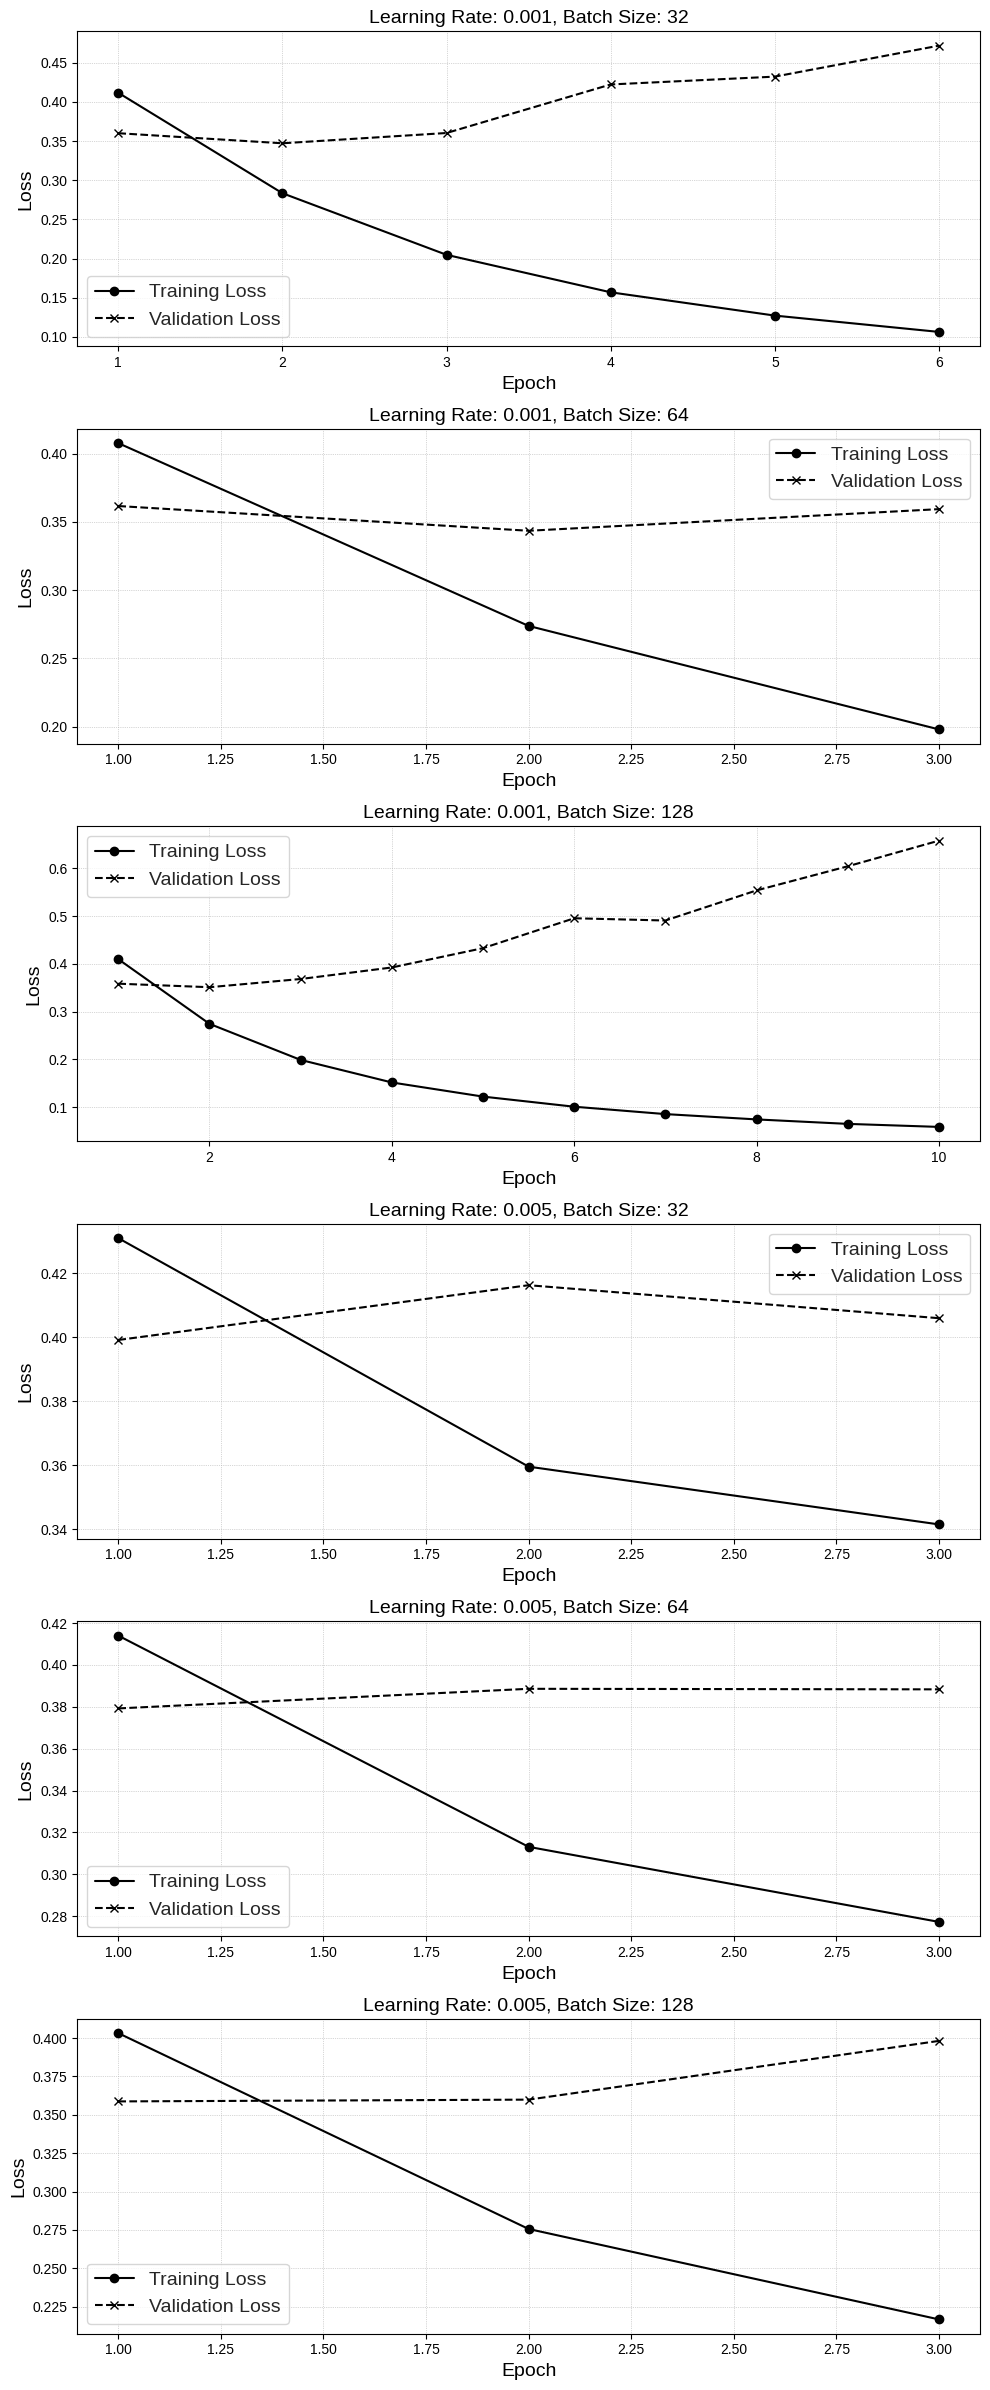

In [62]:

# Plotting loss
plot_train_val_loss(results_df_m1, zoom=None)

In [63]:
# Sorting models by results
sorted_df_m1 = results_df_m1.sort_values(by=('Metrics', 'F1'), ascending=False)

# Displaying
display(sorted_df_m1.head())

,"(Hyperparameters, Learning Rate)","(Hyperparameters, Batch Size)","(Metrics, Epoch)","(Metrics, Training Loss)","(Metrics, Validation Loss)","(Metrics, Accuracy)","(Metrics, F1)","(Metrics, Precision)","(Metrics, Recall)"
15,0.001,128,7,0.085586,0.490766,0.860094,0.814664,0.796350,0.833841
16,0.001,128,8,0.074449,0.553818,0.856876,0.814024,0.781465,0.849414
13,0.001,128,5,0.122205,0.432939,0.855177,0.813997,0.773192,0.859348
12,0.001,128,4,0.151788,0.392481,0.855952,0.812999,0.779805,0.849145
17,0.001,128,9,0.065098,0.604295,0.857487,0.812179,0.790048,0.835586


##### Model 2: Complex

In [64]:
# Running training for Model 2
results_df_m2, last_model_m2, best_model_m2 = training_function_classification(
    model_constructor=lambda: SiameseLSTM2(embedding_matrix=embedding_matrix),
    train_dataset=train_dataset_snn,
    val_dataset=val_dataset_snn,
    device=device,
    learning_rates=[0.001, 0.005],
    num_epochs= 20,
    batch_sizes=[32, 64, 128]
)

LR=0.001, Batch=32:  55%|█████▌    | 11/20 [15:31<12:42, 84.68s/it]


Early stopping at epoch 12 (no F1 improvement for 3 epochs)


LR=0.001, Batch=64:  10%|█         | 2/20 [02:01<18:16, 60.90s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.001, Batch=128:  10%|█         | 2/20 [01:06<09:59, 33.31s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=32:  10%|█         | 2/20 [03:53<35:01, 116.76s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=64:  10%|█         | 2/20 [02:02<18:19, 61.08s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=128:  10%|█         | 2/20 [01:06<10:02, 33.45s/it]

Early stopping at epoch 3 (no F1 improvement for 3 epochs)


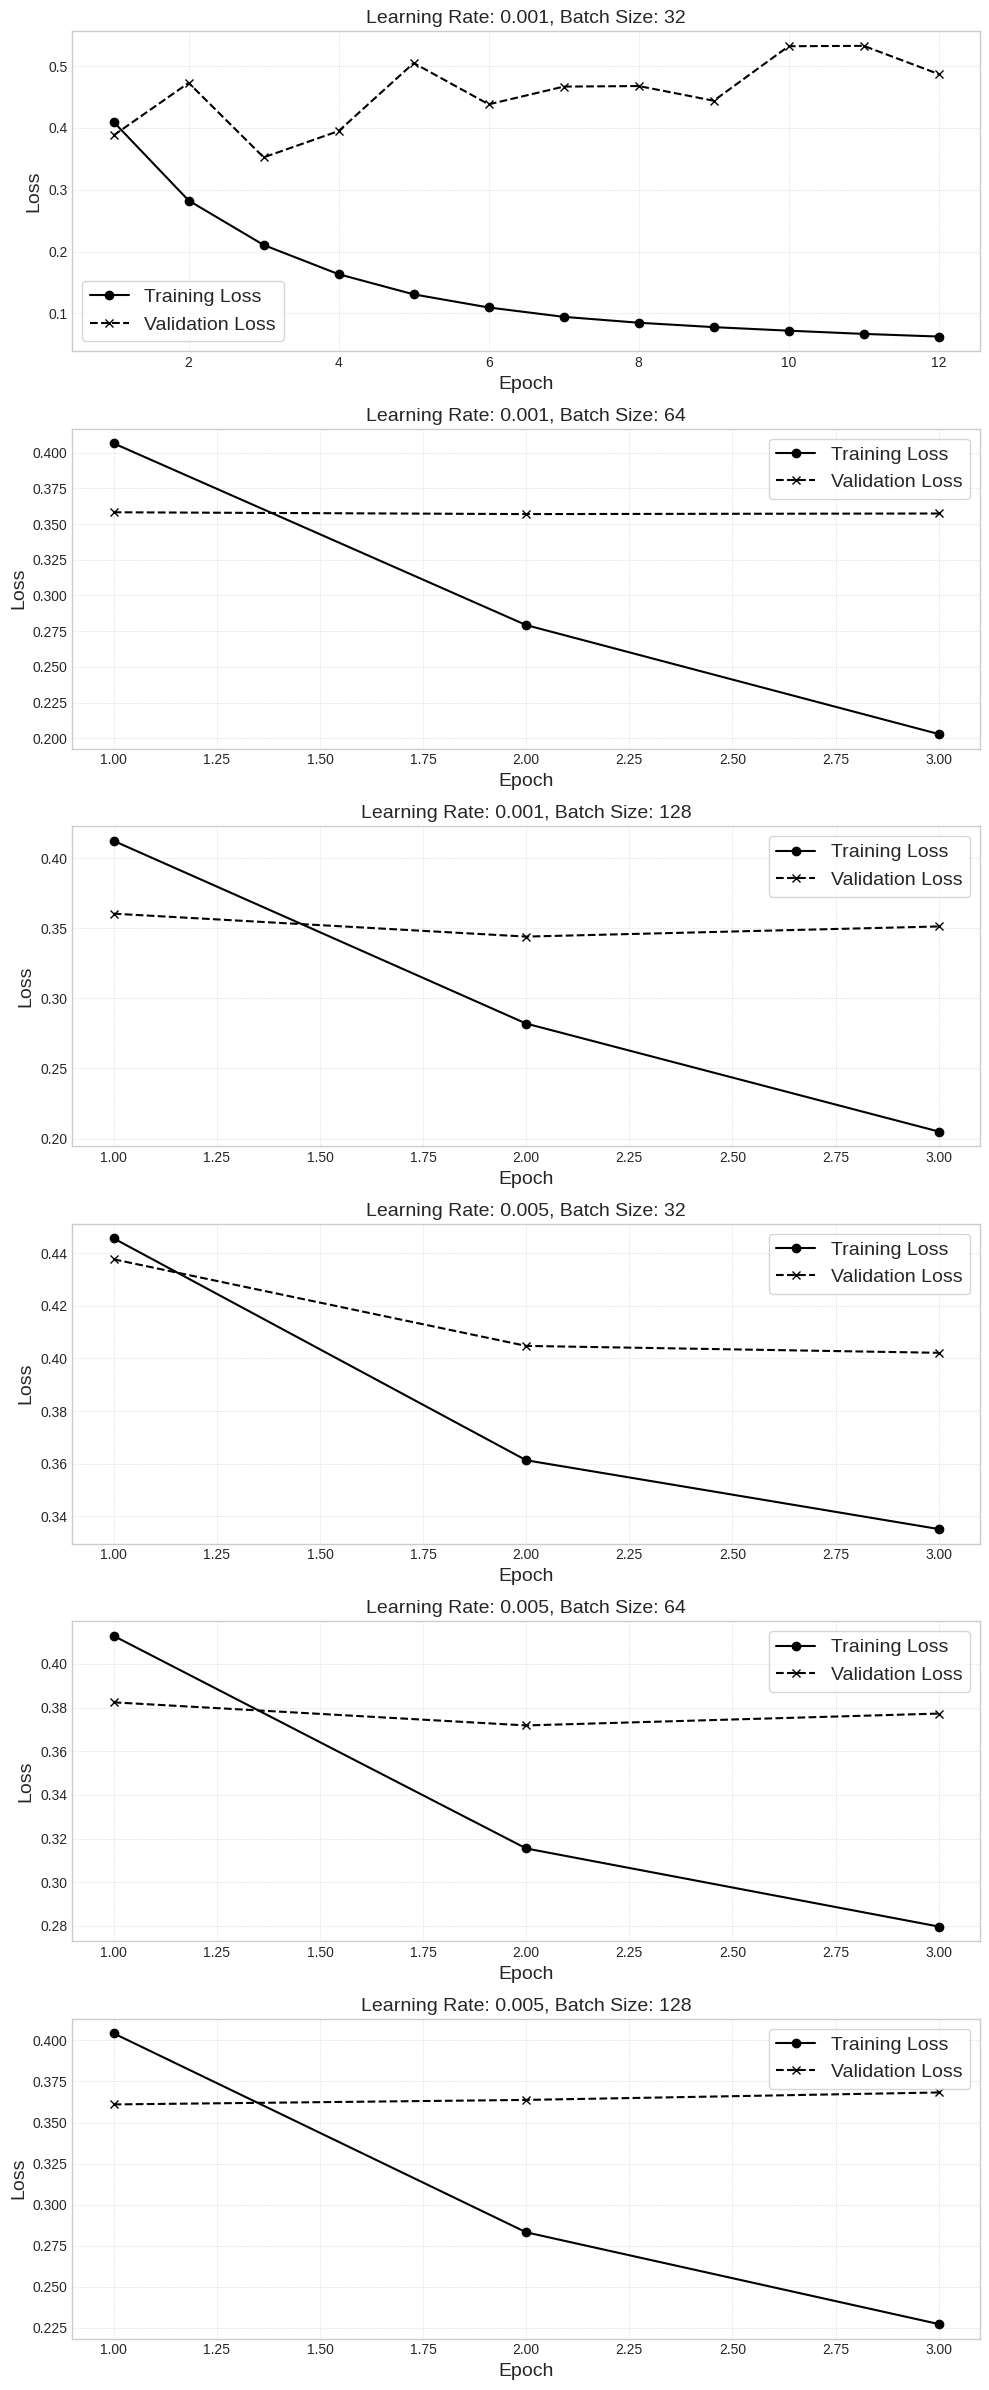

In [65]:
# Plotting loss
plot_train_val_loss(results_df_m2, zoom=None)

In [66]:
# Sorting models by results
sorted_df_m2 = results_df_m2.sort_values(by=('Metrics', 'F1'), ascending=False)

# Displaying
display(sorted_df_m2.head())

,"(Hyperparameters, Learning Rate)","(Hyperparameters, Batch Size)","(Metrics, Epoch)","(Metrics, Training Loss)","(Metrics, Validation Loss)","(Metrics, Accuracy)","(Metrics, F1)","(Metrics, Precision)","(Metrics, Recall)"
8,0.001,32,9,0.077704,0.444119,0.852586,0.814171,0.760700,0.875727
6,0.001,32,7,0.094366,0.466993,0.860986,0.813058,0.806436,0.819789
5,0.001,32,6,0.109513,0.438299,0.861365,0.811995,0.812122,0.811868
3,0.001,32,4,0.163322,0.395106,0.847272,0.811626,0.744372,0.892240
10,0.001,32,11,0.066746,0.532920,0.847850,0.810685,0.749014,0.883424


##### Model 3: M1 with Dropout

In [67]:
# Running training for Model 3
results_df_m3, last_model_m3, best_model_m3 = training_function_classification(
    model_constructor=lambda: SiameseLSTM3(embedding_matrix=embedding_matrix),
    train_dataset=train_dataset_snn,
    val_dataset=val_dataset_snn,
    device=device,
    learning_rates=[0.001, 0.005],
    num_epochs= 20,
    batch_sizes=[32, 64, 128]
)

LR=0.001, Batch=32:  45%|████▌     | 9/20 [12:03<14:44, 80.39s/it]


Early stopping at epoch 10 (no F1 improvement for 3 epochs)


LR=0.001, Batch=64:  10%|█         | 2/20 [01:53<17:04, 56.91s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.001, Batch=128:  10%|█         | 2/20 [01:02<09:24, 31.35s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=32:  10%|█         | 2/20 [03:37<32:34, 108.56s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=64:  10%|█         | 2/20 [01:54<17:07, 57.06s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=128:  10%|█         | 2/20 [01:02<09:24, 31.38s/it]

Early stopping at epoch 3 (no F1 improvement for 3 epochs)


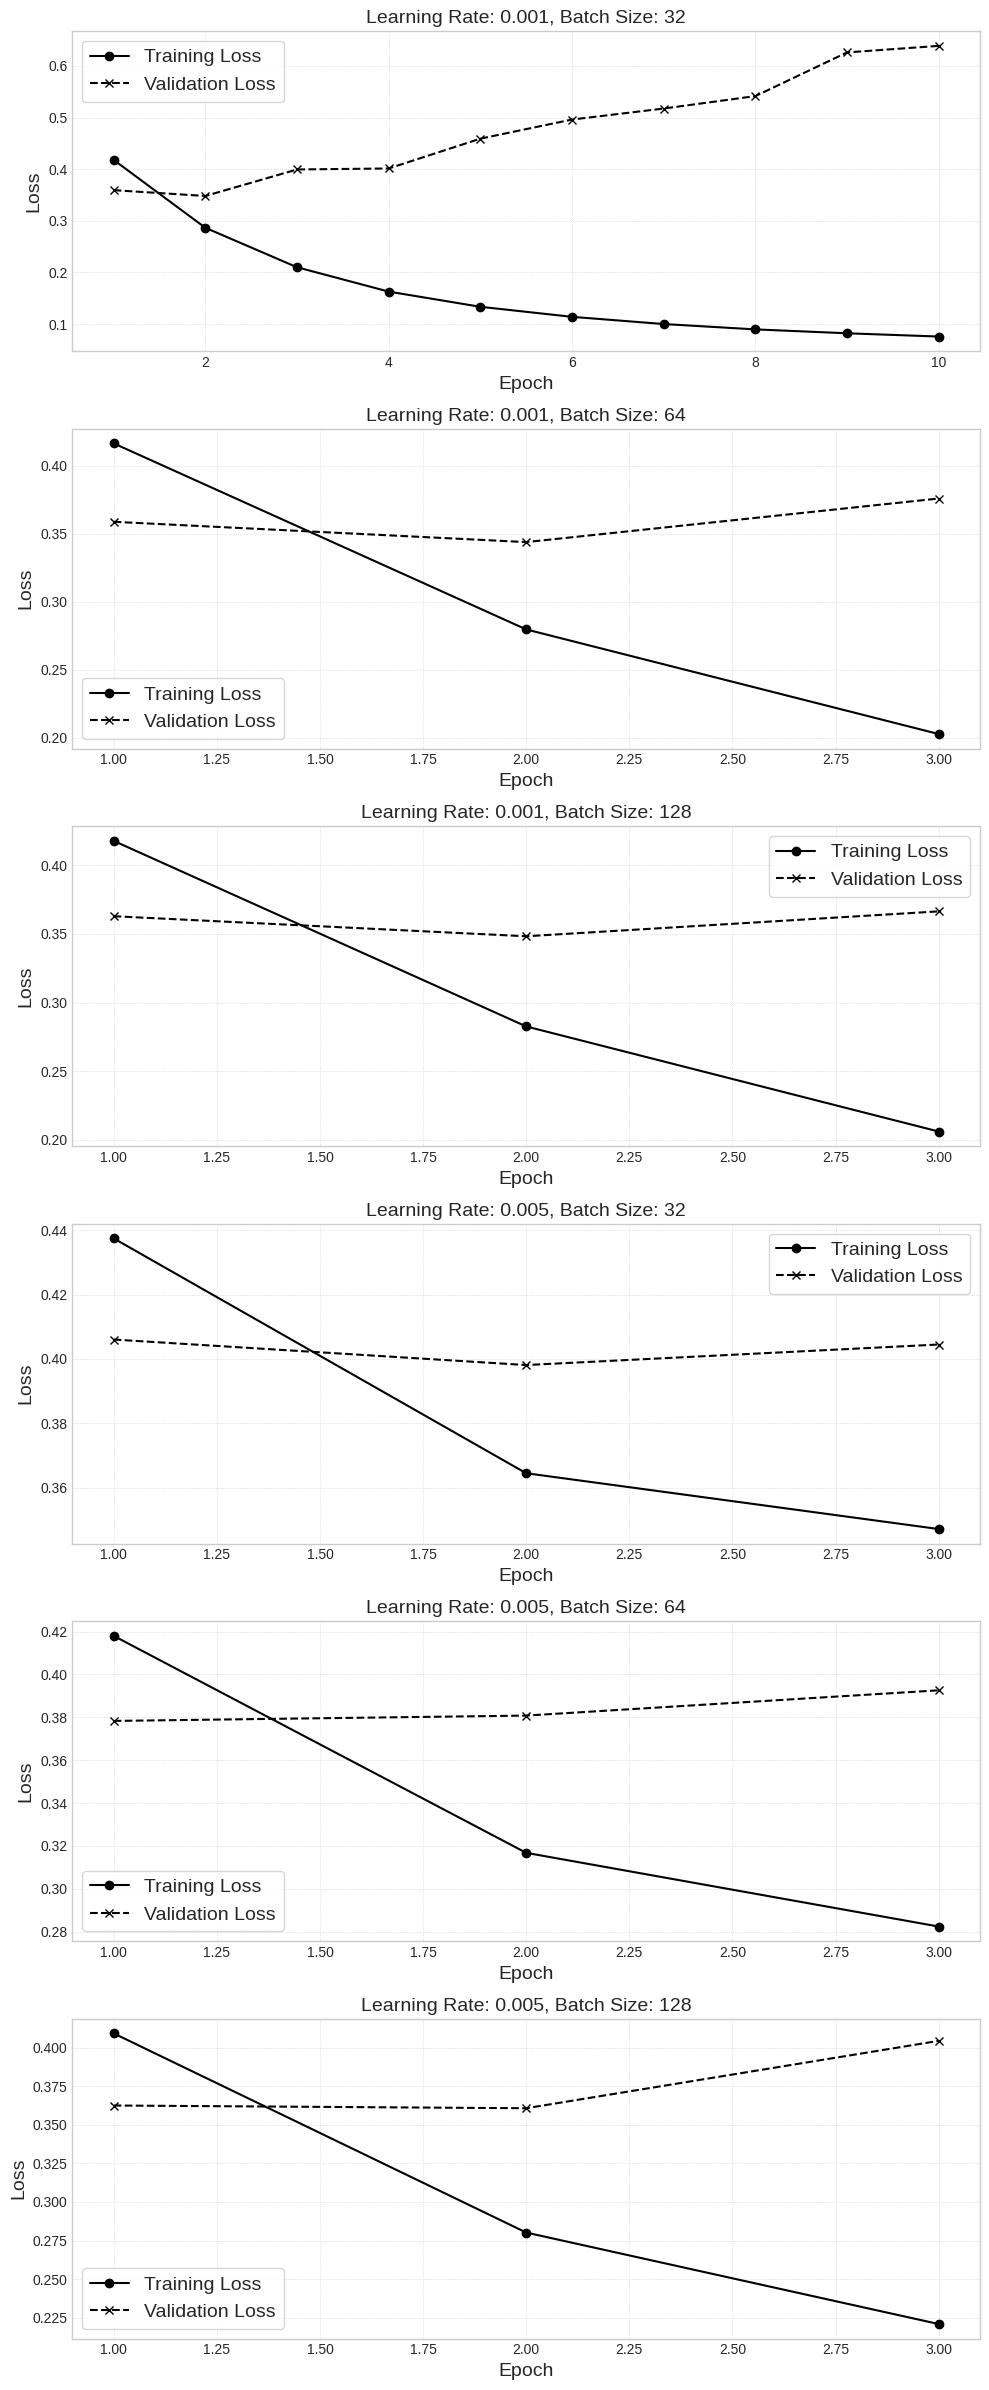

In [68]:
# Plotting loss
plot_train_val_loss(results_df_m3, zoom=None)

In [69]:
# Sorting models by results
sorted_df_m3 = results_df_m3.sort_values(by=('Metrics', 'F1'), ascending=False)

# Displaying
display(sorted_df_m3.head())

,"(Hyperparameters, Learning Rate)","(Hyperparameters, Batch Size)","(Metrics, Epoch)","(Metrics, Training Loss)","(Metrics, Validation Loss)","(Metrics, Accuracy)","(Metrics, F1)","(Metrics, Precision)","(Metrics, Recall)"
6,0.001,32,7,0.100186,0.517511,0.854500,0.814203,0.769405,0.864540
3,0.001,32,4,0.163011,0.401456,0.858675,0.813883,0.791153,0.837958
8,0.001,32,9,0.082302,0.626204,0.856117,0.813029,0.780541,0.848340
12,0.001,64,3,0.202560,0.375902,0.852916,0.812551,0.766496,0.864495
4,0.001,32,5,0.133589,0.459179,0.856200,0.812028,0.783858,0.842298


##### Model 4: M3 with Dropout

In [70]:
# Running training for Model 4
results_df_m4, last_model_m4, best_model_m4 = training_function_classification(
    model_constructor=lambda: SiameseLSTM4(embedding_matrix=embedding_matrix),
    train_dataset=train_dataset_snn,
    val_dataset=val_dataset_snn,
    device=device,
    learning_rates=[0.001, 0.005],
    num_epochs= 20,
    batch_sizes=[32, 64, 128]
)

LR=0.001, Batch=32:  40%|████      | 8/20 [12:02<18:03, 90.33s/it]


Early stopping at epoch 9 (no F1 improvement for 3 epochs)


LR=0.001, Batch=64:  10%|█         | 2/20 [02:05<18:53, 62.96s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.001, Batch=128:  10%|█         | 2/20 [01:08<10:18, 34.37s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=32:  10%|█         | 2/20 [04:00<36:08, 120.50s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=64:  10%|█         | 2/20 [02:05<18:51, 62.89s/it]


Early stopping at epoch 3 (no F1 improvement for 3 epochs)


LR=0.005, Batch=128:  10%|█         | 2/20 [01:08<10:18, 34.34s/it]

Early stopping at epoch 3 (no F1 improvement for 3 epochs)


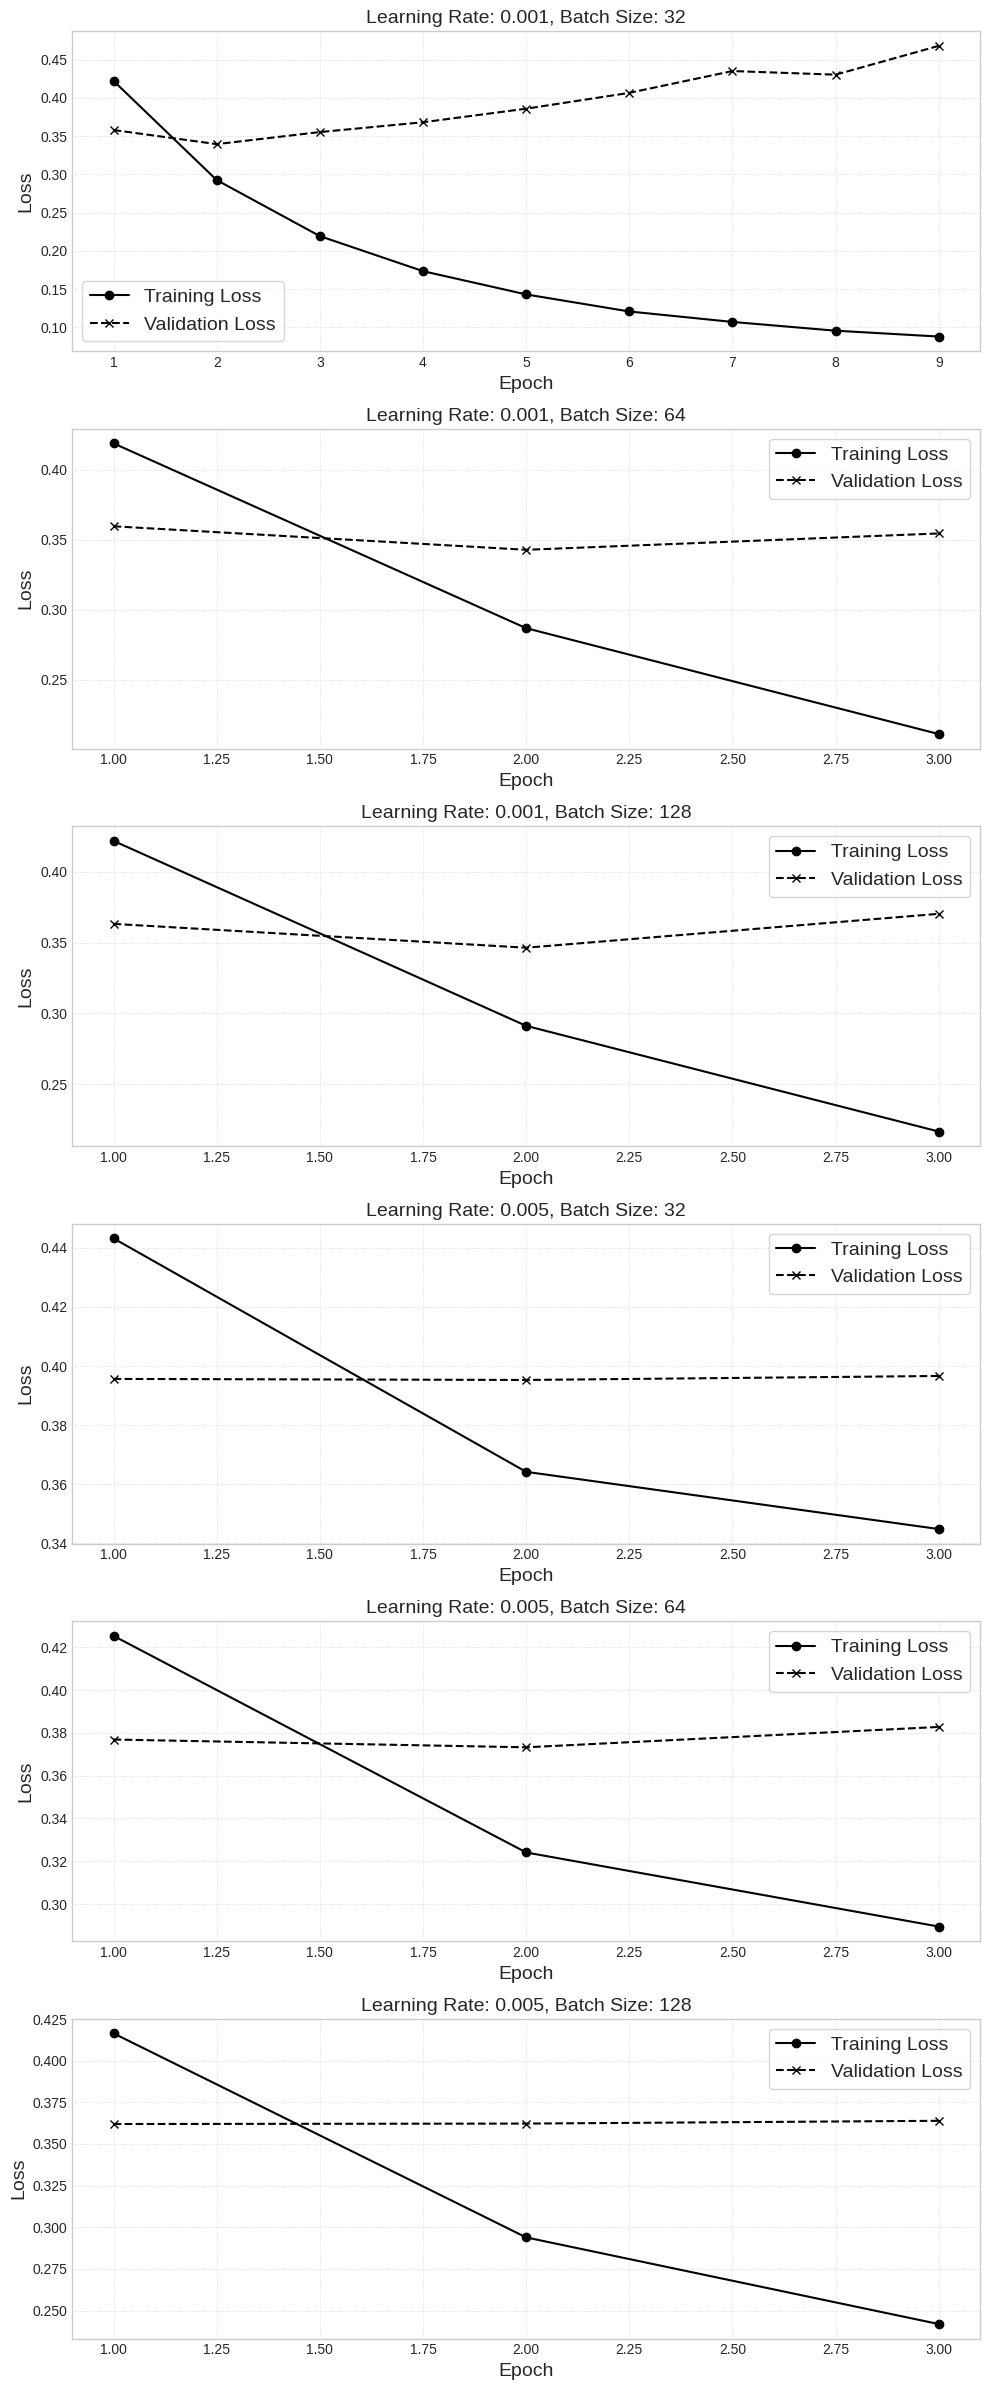

In [71]:
# Plotting loss
plot_train_val_loss(results_df_m4, zoom=None)

In [72]:
# Sorting models by results
sorted_df_m4 = results_df_m4.sort_values(by=('Metrics', 'F1'), ascending=False)

# Displaying
display(sorted_df_m4.head())

,"(Hyperparameters, Learning Rate)","(Hyperparameters, Batch Size)","(Metrics, Epoch)","(Metrics, Training Loss)","(Metrics, Validation Loss)","(Metrics, Accuracy)","(Metrics, F1)","(Metrics, Precision)","(Metrics, Recall)"
5,0.001,32,6,0.120854,0.406456,0.857124,0.816412,0.775812,0.861496
6,0.001,32,7,0.107189,0.434969,0.861299,0.815409,0.800621,0.830753
4,0.001,32,5,0.143147,0.385789,0.859385,0.815351,0.790429,0.841896
8,0.001,32,9,0.088099,0.467864,0.858890,0.815118,0.788538,0.843551
7,0.001,32,8,0.095746,0.430234,0.860787,0.814756,0.799862,0.830216


### NeoBERT

#### Preparation

In [73]:
# Setting model name
model_name2 = "chandar-lab/NeoBERT"



In [74]:
# Tokenizing the questions using the NeoBERT tokenizer

# Initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name2, trust_remote_code=True)

# Define tokenizer function for question pairs
def tokenize_function(examples):
    return tokenizer(
        examples["question1"],
        examples["question2"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Apply tokenizer to the dataset
tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)

# Adding targets to dataset
tokenized_datasets["train"] = tokenized_datasets["train"].add_column("labels", y_train_bert.tolist())
tokenized_datasets["val"] = tokenized_datasets["val"].add_column("labels", y_val_bert.tolist())
tokenized_datasets["test"] = tokenized_datasets["test"].add_column("labels", y_test_bert.tolist())

Map:   0%|          | 0/208784 [00:00<?, ? examples/s]

Map:   0%|          | 0/60598 [00:00<?, ? examples/s]

Map:   0%|          | 0/60599 [00:00<?, ? examples/s]

#### Setting up the model

In [75]:
# Initialize the NeoBERT model
model = AutoModelForSequenceClassification.from_pretrained(model_name2, trust_remote_code=True, num_labels=2)

model.safetensors:   0%|          | 0.00/981M [00:00<?, ?B/s]

Some weights of NeoBERTForSequenceClassification were not initialized from the model checkpoint at chandar-lab/NeoBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'dense.bias', 'dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Data_science/nlp_text_analytics/final_assignment/data/model_outputs",           # Directory for saving model checkpoints
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy='epoch',
    learning_rate=8e-6,              # Start with a small learning rate, 5e-5 tested
    per_device_train_batch_size=32,  # Batch size per GPU
    per_device_eval_batch_size=32,
    num_train_epochs=4,              # Number of epochs
    weight_decay=5e-4,               # Regularization, 0.01 tested
    save_total_limit=2,              # Limit checkpoints to save space
    load_best_model_at_end=True,     # Automatically load the best checkpoint
    logging_dir="/content/drive/MyDrive/Data_science/nlp_text_analytics/final_assignment/data/model_loss",            # Directory for logs
    logging_steps=100,               # Log every 100 steps
    fp16=True,                        # Enable mixed precision for faster training
    metric_for_best_model="f1",
    greater_is_better=True
)

# Instead of pre-padding all tokenized data to a fixed length, this collator pads each batch to the length of the longest sequence in the batch, improving training efficiency.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [77]:
# Helper function to check performance
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = softmax(logits, axis=1)  # convert logits to probabilities
    preds = logits.argmax(axis=1) # Selects the most probable class as the prediction.

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "log_loss": log_loss(labels, probs),
        "f1": f1_score(labels, preds)
    }


#### Training

In [78]:
# Trainer constructor
trainer = Trainer(
    model=model,                        # Pre-trained model
    args=training_args,                 # Training arguments
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,        # Efficient batching
    compute_metrics=compute_metrics     # Custom metric
)

# Early stopping to avoid overfitting
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Log Loss,F1,Runtime,Samples Per Second,Steps Per Second
1,0.238500,0.246342,0.898379,0.814564,0.938953,0.246343,0.872347,79.266200,764.487000,23.894000
2,0.136700,0.292221,0.908677,0.840016,0.930207,0.292220,0.882814,80.398100,753.724000,23.558000
3,0.082400,0.478920,0.908825,0.842447,0.926770,0.478910,0.882599,80.924800,748.818000,23.404000
4,0.024800,0.652211,0.906680,0.836723,0.928912,0.652148,0.880411,80.719700,750.722000,23.464000


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 4096}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters

TrainOutput(global_step=26100, training_loss=0.12982786523428, metrics={'train_runtime': 3674.1226, 'train_samples_per_second': 227.302, 'train_steps_per_second': 7.104, 'total_flos': 1.2751798427959296e+17, 'train_loss': 0.12982786523428, 'epoch': 4.0})

#### Evaluation

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     38189
           1       0.84      0.93      0.88     22409

    accuracy                           0.91     60598
   macro avg       0.90      0.91      0.90     60598
weighted avg       0.91      0.91      0.91     60598



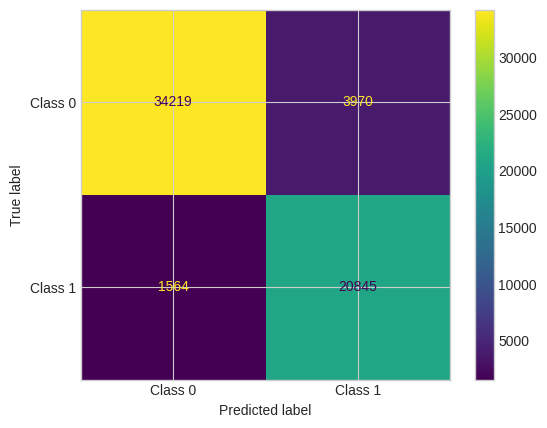

In [79]:
# Generate predictions
predictions = trainer.predict(tokenized_datasets["val"])
predicted_labels_val = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_datasets["val"]["labels"], predicted_labels_val))

# Confusion matrix
cm = confusion_matrix(tokenized_datasets["val"]["labels"], predicted_labels_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

# Saving the models

In [80]:
# Save the NeoBERT model

# Save model and tokenizer
# model.save_pretrained('/content/drive/MyDrive/Data_science/nlp_text_analytics/final_assignment/models')
# tokenizer.save_pretrained('/content/drive/MyDrive/Data_science/nlp_text_analytics/final_assignment/models')

In [81]:
# Save NN
# torch.save(best_model_m4.state_dict(), "/content/drive/MyDrive/Data_science/nlp_text_analytics/final_assignment/models/best_model_m4.pt")

In [82]:
'''
from transformers import AutoModelForSequenceClassification
# Load models
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Data_science/nlp_text_analytics/final_assignment/models/")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Data_science/nlp_text_analytics/final_assignment/models/")

trainer = Trainer(
    model=model,                        # Pre-trained model
    args=training_args,                 # Training arguments
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,        # Efficient batching
    compute_metrics=compute_metrics     # Custom metric
)
'''

'\nfrom transformers import AutoModelForSequenceClassification\n# Load models\nmodel = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Data_science/nlp_text_analytics/final_assignment/models/")\ntokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Data_science/nlp_text_analytics/final_assignment/models/")\n\ntrainer = Trainer(\n    model=model,                        # Pre-trained model\n    args=training_args,                 # Training arguments\n    train_dataset=tokenized_datasets["train"],\n    eval_dataset=tokenized_datasets["val"],\n    tokenizer=tokenizer,\n    data_collator=data_collator,        # Efficient batching\n    compute_metrics=compute_metrics     # Custom metric\n)\n'

## Model Comparison

In [83]:
# Listing all the best models
import time

best_models = {
    'Cosine Baseline BOW': bow_threshold,
    'Cosine Baseline TF-IDF': tfidf_threshold,
    'Cosine Baseline SentenceBERT': sbert_threshold,
    'Logistic Regression BOW': best_model_bow_lr,
    'Logistic Regression TF-IDF': best_model_tfidf_lr,
    'Logistic Regression SentenceBERT': best_model_sbert_lr,
    'Naive Bayes BOW': best_model_bow_nb,
    'Naive Bayes TF-IDF': best_model_tfidf_nb,
    'Naive Bayes SentenceBERT': best_model_sbert_nb,
    'XGBoost BOW': best_model_bow_xgb,
    'XGBoost TF-IDF': best_model_tfidf_xgb,
    'XGBoost SentenceBERT': best_model_sbert_xgb,
    'Siamese LSTM: Model 4': best_model_m4,
    'NeoBERT': model
}

# Iterating through the best models and evaluating them on the test set
for model_name, model in best_models.items():

    # Starting timer to measure evaluation time
    start_time = time.time()

    print(f"\nEvaluating {model_name} on the test set:")

    # Checking which dataset to use
    if 'BOW' in model_name: X_test = X_test_bow
    elif 'TF-IDF' in model_name: X_test = X_test_tfidf
    elif 'SentenceBERT' in model_name: X_test = X_test_sbert
    elif 'LSTM' in model_name: X_test = X_test_snn
    else: X_test = tokenized_datasets["test"]

    # Checking which prediction to use

    # NeoBERT
    if model_name == 'NeoBERT':

        # Setting the test set
        y_true = tokenized_datasets["test"]["labels"]

        # For NeoBERT, we need to use the Trainer's predict method
        predictions = trainer.predict(X_test)
        y_pred = predictions.predictions.argmax(axis=-1)

    # SNN
    elif model_name == 'Siamese LSTM: Model 4':

        # Setting the test set
        y_true = y_test_snn

        # For Siamese LSTM models, we use the DataLoader
        results, all_preds, all_labels = evaluate_model_on_test_set(model, test_loader_snn, device)
        y_pred = (all_preds)

    # Checking if model is Baseline
    elif 'Baseline' in model_name:

        # Setting the test set
        y_true = y_test

        # For Baseline models, the model is a threshold
        y_pred = (X_test['cosine_similarity'] > model).astype(int)

    # Otherwise
    else:

        # Setting the test set
        y_test = y_test

        # For other models, we can use the predict method directly
        y_pred = model.predict(X_test)

    # Print classification report
    print(classification_report(y_true, y_pred))

    # Calculate evaluation time
    evaluation_time = time.time() - start_time
    print(f"\nEvaluation time for {model_name}: {evaluation_time:.2f} seconds\n")


Evaluating Cosine Baseline BOW on the test set:
              precision    recall  f1-score   support

           0       0.88      0.41      0.56     38428
           1       0.47      0.90      0.62     22171

    accuracy                           0.59     60599
   macro avg       0.67      0.66      0.59     60599
weighted avg       0.73      0.59      0.58     60599


Evaluation time for Cosine Baseline BOW: 0.02 seconds


Evaluating Cosine Baseline TF-IDF on the test set:
              precision    recall  f1-score   support

           0       0.89      0.33      0.48     38428
           1       0.44      0.93      0.60     22171

    accuracy                           0.55     60599
   macro avg       0.67      0.63      0.54     60599
weighted avg       0.73      0.55      0.53     60599


Evaluation time for Cosine Baseline TF-IDF: 0.02 seconds


Evaluating Cosine Baseline SentenceBERT on the test set:
              precision    recall  f1-score   support

           0     

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     38428
           1       0.84      0.93      0.88     22171

    accuracy                           0.91     60599
   macro avg       0.90      0.91      0.90     60599
weighted avg       0.91      0.91      0.91     60599


Evaluation time for NeoBERT: 80.43 seconds

